In [5]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [8]:
from IPython.display import display, HTML
display(HTML("<style>.jp-Cell { width: 110% !important; margin:0}</style>"))

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { max-height: 50em; }</style>"))

# Imports

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

from psutil._common import bytes2human
import time
import sys
import numpy as np
import scipy as sp
import torch as tc
# import skdim
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mutual_info_score
from hummingbird.ml import convert
from scipy.integrate import solve_ivp, odeint
import scipy.signal as signal
# import pypsr as pyps
import re
from datetime import datetime
from tqdm.notebook import tqdm, trange
import gzip
import os
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from matplotlib import rc
%matplotlib inline

from numba import jit
from fast_histogram import histogram2d

np.set_printoptions(linewidth=250)

font_dir = 'C:/Users/AdamG/Anaconda3/Lib/site-packages/matplotlib/mpl-data/fonts/ttf/'
# font_dir = '/Users/adamgiammarese/Library/Fonts/'

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Set Directories

In [3]:
base_dir = base_dir = os.getcwd().replace('\\','/') + '/'

fig_dir = base_dir + 'Figures/Logistic Map/'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)

data_dir = base_dir + 'Logistic_Data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

os.chdir(base_dir)

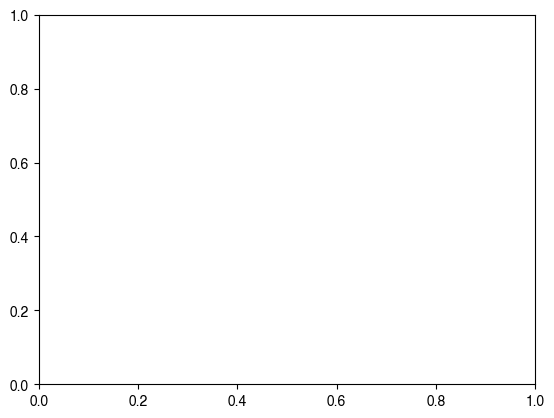

In [4]:
# !cp Helvetica.ttf $font_dir

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
plt.xticks(fontname = 'Helvetica')
plt.yticks(fontname = 'Helvetica')
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{xfrac}')


plt.rcParams['savefig.bbox'] = 'tight'

import matplotlib.font_manager as fm
fm.fontManager.addfont(font_dir + 'Helvetica.ttf')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

prop = fm.FontProperties(fname=font_dir+'Helvetica.ttf')
font = {'fontname':'Helvetica'}

# Helper Functions

In [5]:
tc.backends.cuda.is_built(), tc.backends.cudnn.is_available()

(True, True)

In [69]:
def logistic(x,r=3.57):
    return r*x*(1-x)

def evolve(f,n,x0,r=3.57):
    x = [x0]
    for i in range(1,n):
        x += [f(x[i-1],r)]
    return np.array(x)

def lead_data(data,stride=1,lead=1):
    n_samples = len(data) - lead
    n_dims = data.shape[1]
    features = np.zeros((n_samples//stride,n_dims))
    labels = np.zeros((n_samples//stride,n_dims))
    for i in range(n_samples//stride):
        j = i*stride
        features[i,:] = data[j,:].flatten()
        labels[i,:] = data[j+lead,:].flatten()
    return features, labels

def AMI(x1, x2, bins=10):
    if len(np.shape(x1)) == 2 and np.shape(x1)[1] == 1:
        x1 = np.array(x1).reshape(-1,)
    if len(np.shape(x2)) == 2 and np.shape(x2)[1] == 1:
        x2 = np.array(x2).reshape(-1,)
    return mutual_info_score(None, None, contingency=np.histogram2d(x1, x2, bins=10)[0])

def lagged_AMI(x, max_lag=None, bins=10, normalize=True):
    if max_lag is None:
        max_lag = len(x)//2
    if len(np.shape(x)) == 1:
        return np.array([AMI(x[:len(x)-tau], x[tau:], bins=bins) for tau in range(max_lag)]).reshape(-1,1)
    else:
        return np.array([np.array([AMI(x[:len(x)-tau,i], x[tau:,i], bins=bins)
                          for tau in range(max_lag)])/AMI(x[:,i],x[:,i], bins=bins) for i in range(x.shape[1])]).T

def get_tau_crits(X_train, p_val=0.05, max_lag=600, bins=10, make_plot=False, 
                  dim_labels=['x','y','z'], save_fig=False, fname='',
                  title=None, debug_data=False, peak_order=1,
                  incorporate_peaks=True):
    amis = []
    N = X_train.shape[1]
    
    if dim_labels is None:
        dim_labels = np.arange(N).astype(str)
    
    max_lag = len(X_train)//2 if max_lag is None else min(max_lag,len(X_train)//2)
    lags = np.arange(max_lag)
    amis = lagged_AMI(X_train, max_lag, bins=bins, normalize=True)

#     for i in range(N):
#         lags, ami = pyps.lagged_ami(X_train[:,i], max_lag=max_lag)
#         amis.append(ami)
#     amis = np.array(amis).T
    
#     for i in range(N):
#         amis[:,i] /= amis[0,i]
        
    quantiles = np.quantile(amis, p_val, axis=0)
    
    drop_below_quantile = []
    peaks = []
    for i in range(N):
        peaks.append(sp.signal.argrelextrema(amis[:,i], np.greater, order=peak_order)[0])
        drop_below_quantile.append([])
        for j in range(1,max_lag):
            if amis[j,i] < quantiles[i] and amis[j-1,i] > quantiles[i]:
                drop_below_quantile[i].append(j)
                break
        if j == max_lag-1:
            drop_below_quantile[i].append(1)
        
        
    tau_crits = []
    for i in range(N):
        if incorporate_peaks and len(peaks[i]) > 0:
            tau_crits.append(drop_below_quantile[i][0] if drop_below_quantile[i][0] > peaks[i][0] else (2*peaks[i][0] if peaks[i][0]<max_lag/2 else peaks[i][0]))
        else:
            tau_crits.append(drop_below_quantile[i][0])
#         tau_crits.append(2*drop_below_quantile[i][0] if drop_below_quantile[i][0] < max_lag/2 else drop_below_quantile[i][0])
#         tau_crits.append(drop_below_quantile[i][min(2,len(drop_below_quantile[i])-1)])
#         for j in range(max_lag):
#             if amis[j,i] <= quantiles[i]:#p_val:
#                 break
#         tau_crits += [j-1]
        
    if make_plot:
        fontsize = 32
        ms = 5
        lw = 2
        
        yticks = [0, 0.5, 1]


        ylim = [0,1]
        xy_annotate = (0.01,0.95)

        plt.rc('text', usetex=True)
        plt.rc('xtick',labelsize=fontsize)
        plt.rc('ytick',labelsize=fontsize)
        
        fig, axs = plt.subplots(N,1,figsize=(12,3*N),sharex=True)
        axs_lst = [axs] if N==1 else axs
        
        if title is not None:
            axs[0].set_title(title, fontsize=fontsize)
        
        for i, ax in enumerate(axs_lst):
            ax.plot(lags,amis[:,i],'k',lw=lw)
            
#             ax.axhline(p_val, ls='--', lw=lw, c='r')
            ax.axvline(tau_crits[i], ls='--', lw=lw, c='r')
            
            ax.axhline(quantiles[i], ls=':', lw=lw, c='b')
            ax.axvline(drop_below_quantile[i][0], ls=':', lw=lw, c='b')
            
            ax.set_xlim(0, max_lag-1)
            ax.set_ylim(ylim)
#             ax.text(0.99*max_lag, p_val+0.01, f'$pval={p_val}$', fontsize=fontsize, va='bottom', ha='right',
#                     color='r')
            if tau_crits[i] >= max_lag/2:
                ax.text(tau_crits[i]-0.01*max_lag,0.9,
                     r'$\tau_{'+f'{i+1}'+r',crit}'+r'={:d}$'.format(tau_crits[i]),fontsize=fontsize,
                     va='top', ha='right', color='r')
            else:
                ax.text(tau_crits[i]+0.01*max_lag,0.9,
                     r'$\tau_{'+f'{i+1}'+r',crit}'+r'={:d}$'.format(tau_crits[i]),fontsize=fontsize,
                     va='top', ha='left', color='r')
            
            ax.xaxis.set_major_locator(plt.MaxNLocator(4))
            xticks = ax.get_xticks()
            if max_lag != xticks[-1]:
                ax.xaxis.set_major_locator(plt.MaxNLocator(5))
                xticks = ax.get_xticks()[:-1]
            ax.set_xticks(xticks)
            ax.set_xticklabels([f'{xtick:.0f}' for xtick in xticks], fontsize=fontsize)
            
            
            ax.plot(peaks[i],amis[peaks[i],i],'ro',ms=ms,label='Peaks')
            ax.set_ylabel(r'$AMI_{'+f'{dim_labels[i]}'+r'}(\tau)$', fontsize=fontsize)
            # ax1.legend(loc='upper right',prop={'size': 24})
            ax.annotate(r'\textbf{('+chr(97+i)+')}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
#             ax.set_xticks(xticks)
            # ax1.set_xticklabels(xticks, fontsize=fontsize)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks, fontsize=fontsize)
    
            if i == N - 1:
                ax.set_xlabel(r'$\tau$', fontsize=fontsize)
                
            plt.setp(ax.spines.values(), linewidth=2, zorder=100)
            ax.tick_params(length=10,width=2)
            
            ax.set_zorder(N-i)
    
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.2,wspace=0.15)
        fig.align_labels(axs)
        
        if save_fig:
            plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
            plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

        plt.show()
    
    if debug_data:
        return tau_crits, amis, peaks
    else:
        return tau_crits    

def make_features_and_labels(data,k,xi=1,stride=1,lead=1):
    n_samples = len(data) - (k-1)*xi - lead
    n_dims = data.shape[1]
    features = np.zeros((n_samples//stride,k*n_dims))
    labels = np.zeros((n_samples//stride,n_dims))
    for i in range(n_samples//stride):
        j = i*stride
        features[i,:] = data[j:j+k*xi:xi,:].T.flatten()
        labels[i,:] = data[j+(k-1)*xi+lead,:].flatten()
    return features, labels

def feature_selection(features, labels, n_estimators=100, max_depth=None,
                      random_state=None, n_jobs=-1, n_samples=None,
                      model_type='RFR', verbose=False, return_model=False):
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    start_time = time.time()
    stride = 1 if n_samples is None else len(features)//n_samples
    if model_type == 'RFR':
        Regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs,
                                          verbose=verbose).fit(features[::stride], labels[::stride])
    else:
        Regressor = ExtraTreesRegressor(n_estimators=n_estimators, random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs,
                                        verbose=verbose).fit(features[::stride], labels[::stride])
    end_time = time.time()
    if verbose:
        print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
        print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(Regressor))))
    if return_model:
        return Regressor.feature_importances_, Regressor, end_time-start_time
    else:
        return Regressor.feature_importances_, end_time-start_time

def future_prediction(features=None, labels=None, FIs=None, future=None, p=None, xi=1,
                      n_estimators=200, disp_progress=False, desc='',
                      max_depth=None, random_state=None, n_jobs=-1,
                      min_samples_split=2, min_samples_leaf=1, ccp_alpha=0,
                      max_features=1.0, n_samples=None, model=None, s=None,
                      model_type='ETR', verbose=False, model_conversion=None,
                      device='cuda', debug_plot=False, save_fig=False, fname='',
                      dim_labels=None):
    if labels is None:
        N = np.shape(s)[0]
    else:
        N = np.shape(labels)[1]
    p_original = p
    k = np.shape(FIs)[-1]//N
    if features is not None and np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if labels is not None and np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    if len(np.shape(p)) == 1:
        if verbose or disp_progress:
            print(f'Num features selected (given ind): {len(p)} of {len(FIs)}')
        ind = np.array(p)
    else:
        if len(np.shape(FIs)) == 2:
            all_FIs = FIs
            FIs = np.mean(FIs, axis=0)

            pvalue_thresh = 0.05
            pop_mean = 0
            pvalues = sp.stats.ttest_1samp(all_FIs, pop_mean, axis=0, alternative='greater').pvalue
            ind = np.where(pvalues <= pvalue_thresh)[0]
            if len(ind) == 0:
                ind = np.arange(len(FIs))
            FI_0 = np.min(FIs[ind])
            if len(np.where(FIs >= FI_0)[0])/len(FIs) >= 0.5:
                pop_mean = np.median(FIs)
                pvalues = sp.stats.ttest_1samp(all_FIs, pop_mean, axis=0, alternative='greater').pvalue
                ind = np.where(pvalues <= pvalue_thresh)[0]
                if len(ind) == 0:
                    # ind = np.arange(len(FIs))
                    FI_0 = np.median(FIs)
                else:
                    FI_0 = np.min(FIs[ind])
#             ind = np.where(FIs >= FI_0)[0]
#             p = len(np.where(FIs >= FI_0)[0])
        else:
            FI_0 = np.median(FIs)
        p = len(np.where(FIs >= FI_0)[0])#len(np.where(FIs >= np.mean(FIs))[0])
        if p_original is not None:
            if type(p_original) == str:
                p = round(float(p_original)*p)
            elif type(p_original) != int:
                p = round(p_original*len(FIs))
            else:
                if p_original < 0:
                    p = len(FIs)
        p = min(p, len(FIs))
        if verbose or disp_progress:
            print(f'Num features selected (given mean FIs): {p} of {len(FIs)}')
        ind = np.argsort(-FIs)[:p]

        if debug_plot:
            fontsize = 32
            ms = 10
            lw = 2

            if dim_labels is None:
                dim_labels = np.arange(1,N+1).astype(str)
            
            xy_annotate = (0.01,0.95)
            
            plt.rc('text', usetex=True)
            plt.rc('xtick',labelsize=fontsize)
            plt.rc('ytick',labelsize=fontsize)
            
            fig, axs = plt.subplots(N,1,figsize=(12,3*N),sharex=True,sharey=True)
            axs_lst = [axs] if N==1 else axs
            
            lags = np.arange(k)
            
            FI_0 = np.median(FIs)
            
            # ind = np.where(FIs >= FI_0)[0]
            
            for i, ax in enumerate(axs_lst):
                ax.plot(lags,FIs[i*k:(i+1)*k][::-1],'k',lw=lw)
            #     where = np.where(FIs[i*k-1:(i-1)*k:-1] >= np.median(FIs))[0]
            #     where = np.where(pvalues[i*k-1:(i-1)*k:-1] >= pvalue_thresh)[0]
            #     ax.plot(lags[where], FIs[i*k-1:(i-1)*k:-1][where], 'b.', ms=10, zorder=10)
            
            #     ind_tmp = np.where(FIs[i*k:(i+1)*k] >= FI_0)[0]
                
                
                ind_tmp = ind[np.where(np.logical_and(ind <= (i+1)*k-1, ind >= i*k))[0]]
                
            # #     pvalues_tmp = pvalues[i*k:(i+1)*k]
            # #     where = np.where(pvalues_tmp >= pvalue_thresh)[0]
            # #     if len(where) == 0:
            # #         ind_tmp = np.arange(k)[np.argmax(pvalues_tmp):]
            # #     else:
            # #         ind_tmp = np.arange(k)[where[-1]:]
            
                ax.plot((i+1)*k-1-ind_tmp,FIs[ind_tmp],'b.',ms=10)
                
                ax.axhline(FI_0, ls='--', c='r', lw=lw)
            
                ax.set_xlim(0, max(lags))# k-1)
                ax.set_ylim(0, None)
                
                xticks = ax.get_xticks()
                ax.set_xticks(xticks)
                ax.set_xticklabels([f'{xtick:.0f}' for xtick in xticks], fontsize=fontsize)
                
                ax.text(0.99*ax.get_xlim()[1], FI_0+0.05*np.diff(ax.get_ylim()), r'$\text{median}(\mathbf{FI})$', fontsize=fontsize, va='bottom', ha='right',
                        color='r')
            
                ax.set_ylabel(r'$FI_{'+'{:}'.format(dim_labels[i])+r'}(\tau)$', fontsize=fontsize)
                # ax1.legend(loc='upper right',prop={'size': 24})
                if N > 26:
                    ax.annotate(r'\textbf{(\roml{'+str(i+1)+'})}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
                else:
                    ax.annotate(r'\textbf{('+chr(97+i)+')}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
            #             ax.set_xticks(xticks)
                yticks = ax.get_yticks()
                ax.set_yticks(yticks)
                ax.set_yticklabels(yticks, fontsize=fontsize)
            
                if i == N - 1:
                    ax.set_xlabel(r'$\tau$', fontsize=fontsize)
            
                plt.setp(ax.spines.values(), linewidth=2, zorder=100)
                ax.tick_params(length=10,width=2)
            
                ax.set_zorder(N-i)
            
            plt.tight_layout()
            plt.subplots_adjust(hspace=0.2,wspace=0.15)
            fig.align_labels(axs)
            
            if save_fig:
                plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
                plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
            
            plt.show()


    
    start_time = time.time()
    if model is None:
        stride = 1 if n_samples is None else len(features)//n_samples if type(n_samples) == int else round(len(features)*n_samples)
        if model_type == 'RFR':
            model = RandomForestRegressor(n_estimators=n_estimators,
                                          random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          ccp_alpha=ccp_alpha, verbose=verbose)
            #         elif model_type == 'GBR':
            #             model = GradientBoostingRegressor(n_estimators=n_estimators, random_state=random_state, max_depth=max_depth, verbose=True)
            #         elif model_type == 'HGBR':
            #             model = HistGradientBoostingRegressor(max_iter=n_estimators, random_state=random_state, verbose=True)
        else:
            model = ExtraTreesRegressor(n_estimators=n_estimators,
                                        random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs,
                                        max_features=max_features,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        ccp_alpha=ccp_alpha, verbose=verbose)
        model = model.fit(features[::stride,ind],labels[::stride])
        
        end_time = time.time()
        if verbose or disp_progress:
            print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
            print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(model))))
            
    if model_conversion == 'hummingbird':
        start_convert = time.time()
        model = convert(model, 'torch', extra_config={"tree_implementation":"tree_trav"})
        model.to(device)
        end_convert = time.time()
        if verbose or disp_progress:
            print(f'Conversion time ({model_conversion}):', datetime.utcfromtimestamp(end_convert-start_convert).strftime('%H hours, %M minutes, %S.%f seconds'))
            
            
    prediction = np.zeros((future,N))
    if s is None:
        s = np.hstack((features[-1].reshape((N,k*xi))[:,1:],labels[-1].reshape(-1,1)))#features[-1].reshape((N,k*xi)) # shape (N, k*xi)
    else:
        s = s.reshape((N,k*xi)) # shape (N, k*xi)
    s_delayed = s[:,-(k-1)*xi-1::xi] # shape (N, k)

    if disp_progress:
        lst = trange(future,desc=desc)
    else:
        lst = range(future)
    for i in lst:
        y_pred = model.predict(s_delayed.flatten()[ind].reshape(1, -1))[0].reshape((N,1))
        prediction[i,:] = y_pred.reshape(-1,)
        s = np.hstack((s.reshape((N,k*xi))[:,1:],y_pred))
        s_delayed = s[:,-(k-1)*xi-1::xi]
    prediction = np.array(prediction)
    end_time = time.time()
    if verbose or disp_progress:
        print('Total time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
    return prediction, model, end_time-start_time

def future_prediction_lead(features, labels, FIs, future, lead=1, p=None, xi=1, n_estimators=200,
                           disp_progress=False, desc='', leave=False, max_depth=None, random_state=None,
                           n_jobs=-1, min_samples_split=2, min_samples_leaf=1, ccp_alpha=0, max_features=1.0,
                           n_samples=None, model=None, y_train=None, y_test=None, model_type='RFR', verbose=False,
                           open_loop=True, model_conversion=None, device='cuda', debug_plot=False, save_fig=False, fname='',
                           dim_labels=None):
    N = np.shape(labels)[1]
    p_original = p
    k = np.shape(FIs)[-1]//N
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    if len(np.shape(p)) == 1:
        if verbose or disp_progress:
            print(f'Num features selected (given ind): {len(p)} of {len(FIs)}')
        ind = np.array(p)
    else:
        if len(np.shape(FIs)) == 2:
            all_FIs = FIs
            FIs = np.mean(FIs, axis=0)

            pvalue_thresh = 0.05
            pop_mean = 0
            pvalues = sp.stats.ttest_1samp(all_FIs, pop_mean, axis=0, alternative='greater').pvalue
            ind = np.where(pvalues <= pvalue_thresh)[0]
            if len(ind) == 0:
                ind = np.arange(len(FIs))
            FI_0 = np.min(FIs[ind])
            if len(np.where(FIs >= FI_0)[0])/len(FIs) >= 0.5:
                pop_mean = np.median(FIs)
                pvalues = sp.stats.ttest_1samp(all_FIs, pop_mean, axis=0, alternative='greater').pvalue
                ind = np.where(pvalues <= pvalue_thresh)[0]
                if len(ind) == 0:
                    # ind = np.arange(len(FIs))
                    FI_0 = np.median(FIs)
                else:
                    FI_0 = np.min(FIs[ind])
#             ind = np.where(FIs >= FI_0)[0]
#             p = len(np.where(FIs >= FI_0)[0])
        else:
            FI_0 = np.median(FIs)
        p = len(np.where(FIs >= FI_0)[0])#len(np.where(FIs >= np.mean(FIs))[0])
        if p_original is not None:
            if type(p_original) == str:
                p = round(float(p_original)*p)
            elif type(p_original) != int:
                p = round(p_original*len(FIs))
            else:
                if p_original <= 0:
                    p = len(FIs)
        p = min(p, len(FIs))
        if verbose or disp_progress:
            print(f'Num features selected (given mean FIs): {p} of {len(FIs)}')
        ind = np.argsort(-FIs)[:p]

        if debug_plot:
            fontsize = 32
            ms = 10
            lw = 2

            if dim_labels is None:
                dim_labels = np.arange(1,N+1).astype(str)
            
            xy_annotate = (0.01,0.95)
            
            plt.rc('text', usetex=True)
            plt.rc('xtick',labelsize=fontsize)
            plt.rc('ytick',labelsize=fontsize)
            
            fig, axs = plt.subplots(N,1,figsize=(12,3*N),sharex=True,sharey=True)
            axs_lst = [axs] if N==1 else axs
            
            lags = np.arange(k)
            
            FI_0 = np.median(FIs)
            
            # ind = np.where(FIs >= FI_0)[0]
            
            for i, ax in enumerate(axs_lst):
                ax.plot(lags,FIs[i*k:(i+1)*k][::-1],'k',lw=lw)
            #     where = np.where(FIs[i*k-1:(i-1)*k:-1] >= np.median(FIs))[0]
            #     where = np.where(pvalues[i*k-1:(i-1)*k:-1] >= pvalue_thresh)[0]
            #     ax.plot(lags[where], FIs[i*k-1:(i-1)*k:-1][where], 'b.', ms=10, zorder=10)
            
            #     ind_tmp = np.where(FIs[i*k:(i+1)*k] >= FI_0)[0]
                
                
                ind_tmp = ind[np.where(np.logical_and(ind <= (i+1)*k-1, ind >= i*k))[0]]
                
            # #     pvalues_tmp = pvalues[i*k:(i+1)*k]
            # #     where = np.where(pvalues_tmp >= pvalue_thresh)[0]
            # #     if len(where) == 0:
            # #         ind_tmp = np.arange(k)[np.argmax(pvalues_tmp):]
            # #     else:
            # #         ind_tmp = np.arange(k)[where[-1]:]
            
                ax.plot((i+1)*k-1-ind_tmp,FIs[ind_tmp],'b.',ms=10)
                
                ax.axhline(FI_0, ls='--', c='r', lw=lw)
            
                ax.set_xlim(0, max(lags))# k-1)
                ax.set_ylim(0, None)
                
                xticks = ax.get_xticks()
                ax.set_xticks(xticks)
                ax.set_xticklabels([f'{xtick:.0f}' for xtick in xticks], fontsize=fontsize)
                
                ax.text(0.99*ax.get_xlim()[1], FI_0+0.05*np.diff(ax.get_ylim()), r'$\text{median}(\mathbf{FI})$', fontsize=fontsize, va='bottom', ha='right',
                        color='r')
            
                ax.set_ylabel(r'$FI_{'+'{:}'.format(dim_labels[i])+r'}(\tau)$', fontsize=fontsize)
                # ax1.legend(loc='upper right',prop={'size': 24})
                if N > 26:
                    ax.annotate(r'\textbf{(\roml{'+str(i+1)+'})}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
                else:
                    ax.annotate(r'\textbf{('+chr(97+i)+')}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
            #             ax.set_xticks(xticks)
                yticks = ax.get_yticks()
                ax.set_yticks(yticks)
                ax.set_yticklabels(yticks, fontsize=fontsize)
            
                if i == N - 1:
                    ax.set_xlabel(r'$\tau$', fontsize=fontsize)
            
                plt.setp(ax.spines.values(), linewidth=2, zorder=100)
                ax.tick_params(length=10,width=2)
            
                ax.set_zorder(N-i)
            
            plt.tight_layout()
            plt.subplots_adjust(hspace=0.2,wspace=0.15)
            fig.align_labels(axs)
            
            if save_fig:
                plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
                plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
            
            plt.show()
    
    start_time = time.time()
    if model is None:
        stride = 1 if n_samples is None else len(features)//n_samples if type(n_samples) == int else round(len(features)*n_samples)
        if model_type == 'RFR':
            model = RandomForestRegressor(n_estimators=n_estimators,
                                          random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          ccp_alpha=ccp_alpha, verbose=verbose)
        else:
            model = ExtraTreesRegressor(n_estimators=n_estimators,
                                        random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs,
                                        max_features=max_features,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        ccp_alpha=ccp_alpha, verbose=verbose)
        model = model.fit(features[::stride,ind],labels[::stride])
        end_time = time.time()
        
        end_time = time.time()
        if verbose or disp_progress:
            print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
            print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(model))))
            
        if model_conversion == 'hummingbird':
            start_convert = time.time()
            model = convert(model, 'torch', extra_config={"tree_implementation":"tree_trav"})
            model.to(device)
            end_convert = time.time()
            if verbose or disp_progress:
                print(f'Conversion time ({model_conversion}):', datetime.utcfromtimestamp(end_convert-start_convert).strftime('%H hours, %M minutes, %S.%f seconds'))
    
    
    if open_loop:
        s = y_train[-(k-1)*xi-lead:len(y_train)-(lead-1)].T.flatten().reshape((N,(k-1)*xi+1))
        s_delayed_open_loop = np.zeros((future,p))
        for i in range(future):
            s_delayed_open_loop[i,:] = s[:,::xi].flatten()[ind]
            if i >= lead - 1:
                s = np.hstack((s[:,1:].flatten(),y_test[i+1-lead])).reshape((N,(k-1)*xi+1))
            else:
                s = np.hstack((s[:,1:].flatten(),y_train[len(y_train)-(lead-1)+i])).reshape((N,(k-1)*xi+1))
            
        prediction = model.predict(s_delayed_open_loop)
    else:
        prediction = np.zeros((future,N))

        s = y_train[-(k-1)*xi-lead:len(y_train)-(lead-1)].T.flatten().reshape((N,(k-1)*xi+1))
        s_delayed = s[:,::xi]
        
        if disp_progress:
            lst = trange(future,desc=desc,leave=leave)
        else:
            lst = range(future)
        for i in lst:
            y_pred = model.predict(s_delayed.flatten()[ind].reshape(1, -1))[0].reshape((N,1))
            prediction[i,:] = y_pred
            if i >= lead - 1:
                s = np.hstack((s[:,1:].flatten(),y_test[i+1-lead])).reshape((N,(k-1)*xi+1))
            else:
                s = np.hstack((s[:,1:].flatten(),y_train[len(y_train)-(lead-1)+i])).reshape((N,(k-1)*xi+1))
            s_delayed = s[:,::xi]
            
    prediction = np.array(prediction).reshape(-1,N)
        
    end_time = time.time()
    if verbose or disp_progress:
        print('Total time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
    return prediction, model, end_time-start_time
    
def rmse(x,y,z,x_result,y_result,z_result,cutoff=0,rm_transient=0):
    x_diff_sq = np.power(x[cutoff+rm_transient:] - x_result[cutoff:],2)
    y_diff_sq = np.power(y[cutoff+rm_transient:] - y_result[cutoff:],2)
    z_diff_sq = np.power(z[cutoff+rm_transient:] - z_result[cutoff:],2)
    return np.sqrt((x_diff_sq + y_diff_sq + z_diff_sq)/3)

def rmse_vec(y_test,y_pred):
    return np.sqrt(np.mean(np.vstack([(y_test[:,i]-y_pred[:,i])**2 for i in range(y_test.shape[1])]), axis=0))

def envelope_length(y_test,y_pred,threshold=5):
    error_signal = rmse_vec(y_test,y_pred)
    return np.argmax(error_signal > threshold)

def lyapunov_time(t,LE_max,cutoff=0,rm_transient=0):
    return (t[cutoff+rm_transient:]-t[cutoff+rm_transient])/LE_max

def get_left_bin_edge(val,bin_edges):
    for i in range(len(bin_edges)):
        if bin_edges[i] > val:
            break
    return bin_edges[i-1], i-1

def get_bottom_height(current_rects,hist,index,scaling=1):
    bottom = current_rects[index]
    height = 1#/hist[index]
    return bottom*scaling, height*scaling

def add_rect_to_plot(left,bottom,width,height,color,ax=None,alpha=1,zorder=None):
    if zorder is None:
        rect=mpatches.Rectangle((left,bottom),width,height,fill=True,
                            facecolor=color,linewidth=0,edgecolor=color,alpha=alpha)#,facecolor=color)
    else:
        rect=mpatches.Rectangle((left,bottom),width,height,fill=True,zorder=zorder,
                            facecolor=color,linewidth=0,edgecolor=color,alpha=alpha)
    if ax is None:
        plt.gca().add_patch(rect)
    else:
        ax.add_patch(rect)

def delay_embedding_multidimensional(data, emb_dim, n=None, tau=1):
    # input is shape (n_dims,n_samples)
    data = np.array(data)
    if n is None:
        n = data.shape[1] - (emb_dim-1)*tau
    embedding = np.zeros((n,emb_dim*len(data)))
    for i in range(n):
        j = i
        embedding[i,:] = data[:,j:j+emb_dim*tau:tau].flatten()
    return embedding

def RMSE_summary(y_pred, y_test):
    if len(np.shape(y_test)) == 2 and np.shape(y_test)[1] > 1:
        res = []
        for i in range(np.shape(y_test)[1]):
            res.append(np.sqrt(np.mean((y_pred[:,i]-y_test[:,i])**2)))
        return np.mean(res)
    return np.sqrt(np.mean((y_pred-y_test)**2))

def PCC_summary(y_pred, y_test):
    if len(np.shape(y_test)) == 2 and np.shape(y_test)[1] > 1:
        res = []
        for i in range(np.shape(y_test)[1]):
            o_dev = y_test[:,i] - np.mean(y_test[:,i])
            p_dev = y_pred[:,i] - np.mean(y_pred[:,i])
            res.append(np.sum(o_dev*p_dev)/(np.sqrt(np.sum(o_dev**2))*np.sqrt(np.sum(p_dev**2))))
        return np.mean(res)
    o_dev = y_test - np.mean(y_test)
    p_dev = y_pred - np.mean(y_pred)
    return np.sum(o_dev*p_dev)/(np.sqrt(np.sum(o_dev**2))*np.sqrt(np.sum(p_dev**2)))

def AMI_summary(y_pred, y_test, bins=10, normalize=True):
    if len(np.shape(y_test)) == 2 and np.shape(y_test)[1] > 1:
        return np.mean([AMI(y_pred[:,i], y_test[:,i], bins=bins)/(AMI(y_test[:,i], y_test[:,i], bins=bins)
                                                                  if normalize else 1) for i in range(np.shape(y_test)[1])])
    return AMI(y_pred, y_test, bins=bins)/(AMI(y_test, y_test, bins=bins) if normalize else 1)

def get_hausdorff_dimension_data(data, num=40, lims=(0.01, 50), remove_pval=0):
    if lims is None:
        dist_mat = euclidean_distances(data, data)
#         lims = np.min(dist_mat[np.triu_indices(len(dist_mat), 1)]), np.max(dist_mat)
        lims = (np.min(dist_mat[np.nonzero(dist_mat)]),
                min([(np.max(data[:,i])-np.min(data[:,i])) for i in range(data.shape[1])])) #np.max(dist_mat)
        del dist_mat
    lin_lims = np.log(lims)
#     lims = np.exp([lin_lims[0]+remove_pval*np.diff(lin_lims)[0]/2,
#                    lin_lims[1]-remove_pval*np.diff(lin_lims)[0]/2])
    lims = np.exp([lin_lims[0]+remove_pval*np.diff(lin_lims)[0],
                   lin_lims[1]])
#     lims = np.exp([lin_lims[0],
#                    lin_lims[1]-remove_pval*np.diff(lin_lims)[0]])
    return _get_hausdorff_dimension_data(data, num, lims)

# @jit(nopython=False, parallel=True, nogil=False)
def _get_hausdorff_dimension_data(data, num, lims):
    scales = np.geomspace(lims[0], lims[1], num=num)
    ranges = [(np.min(data[:,i]), np.max(data[:,i])) for i in range(data.shape[1])]
    Ns = np.zeros((num))
    for i, scale in enumerate(scales):
#         if data.shape[1] == 2:
#             H = histogram2d(data[:,0], data[:,1], [round((ranges[i][1]-ranges[i][0])/scale) for i in range(2)],
#                             ranges)
#         else:
        H, _ = np.histogramdd(data, bins=[np.arange(ranges[i][0],ranges[i][1],scale) for i in range(data.shape[1])])
        Ns[i] = np.sum(H>0)
        
    return scales[Ns>0], Ns[Ns>0]

def hausdorff_dimension(data, num=40, lims=None, remove_pval=0, mode='highest_r2', param=10, debug_plots=False, debug_data=False):
    scales, Ns = get_hausdorff_dimension_data(data, num, lims, remove_pval)
    scales_log = np.log(scales)
    Ns_log = np.log(Ns)
    
    if mode == 'highest_slope' or mode == 'highest_r2' or mode == 'highest_product':
        def subarrays(n, x):
            return np.fromfunction(lambda i, j: x[i + j], (len(x) - n + 1, n), 
                                   dtype=int)
        
        if type(param) == int:
            min_pts = param
        else:
            min_pts = round(param*num)

        indices = np.arange(len(Ns))
        windows = []
        for i, window_length in enumerate(range(min_pts, len(Ns))):
            windows += subarrays(window_length, indices).tolist()

        slopes, r2_values = np.zeros((len(windows),)), np.zeros((len(windows),))
        for i, window in enumerate(windows):
            slope, _, r_value, _, _ = sp.stats.linregress(scales_log[window], Ns_log[window])
            slopes[i], r2_values[i] = slope, r_value**2
        
        if mode == 'highest_slope':
            i = np.argmax(np.abs(slopes))
        elif mode == 'highest_r2':
            i = np.argmax(r2_values)
        else:
            i = np.argmax(np.abs(slopes)*r2_values)
            
        start_ind, end_ind = windows[i][0], windows[i][-1]
    else:
        thresh = param
        diff2 = np.gradient(np.gradient(np.log(Ns)))

        linear_inds = np.where(np.logical_and(diff2 >= -thresh, diff2 <= thresh))[0]
        jump_inds = np.where(np.diff(linear_inds) > 1)[0]
        jump_inds = np.unique(np.hstack(([0],jump_inds,[len(linear_inds)-1])))
        ind_maxjump = np.argmax(np.diff(jump_inds))
        start_ind, end_ind = jump_inds[ind_maxjump:ind_maxjump+2]
        start_ind += 1
        start_ind, end_ind = linear_inds[[start_ind, end_ind]]
#         jumps = np.where(np.diff(linear_inds) > 1)[0]
#         linear_widths = np.diff(np.hstack(([0],jumps)))
#         start_ind, end_ind = linear_inds[0], np.where(np.diff(linear_inds) > 1)[0][0]
    

    coeffs = np.polyfit(scales_log[start_ind:end_ind],
                        Ns_log[start_ind:end_ind],deg=1)
    poly = np.poly1d(coeffs)
    yfit = np.exp(poly(scales_log[start_ind:end_ind]))


    if debug_plots:
        fontsize = 24
        lw = 2

        plt.rc('text', usetex=True)
        plt.rc('xtick',labelsize=fontsize)
        plt.rc('ytick',labelsize=fontsize)


        fig, axs = plt.subplots(2,1,figsize=(10,12),height_ratios=(1,2))
        ax1, ax2 = axs

        if mode == 'highest_slope' or mode == 'highest_r2' or mode == 'highest_product':
            window_lens = [len(window) for window in windows]
            
            scatter = ax1.scatter(r2_values, slopes, s=5, c=window_lens)
            ax1.plot(r2_values[i], slopes[i], 'ro', ms=10)
            
            ax1.set_xlabel(r'R$^2$ Values', fontsize=fontsize)
            ax1.set_ylabel(r'Slopes', fontsize=fontsize)
            
            cbar = plt.colorbar(scatter, ax=ax1, location='top')
            cbar.set_label('Window Length', fontsize=fontsize)
        else:
            ax1.plot(np.arange(num), diff2, 'k', lw=2)
            ax1.plot(np.arange(start_ind, end_ind), diff2[start_ind:end_ind], 'o', c='orange', ms=10, mew=2, mfc='none')
            ax1.axhline(0, c='k', ls='--', lw=lw)
            ax1.axhline(thresh, c='k', ls=':', lw=lw/2)
            ax1.axhline(-thresh, c='k', ls=':', lw=lw/2)
            ax1.fill_between([0,len(diff2)], -thresh, thresh, color='k', alpha=0.1)

            ax1.set_xlim(0,len(diff2))

            ax1.set_xlabel('Index', fontsize=fontsize)
            ax1.set_ylabel('Second Derivative', fontsize=fontsize)

        ax2.plot(scales_log, Ns_log,'ko',ms=8)

        ax2.plot(scales_log[start_ind:end_ind],Ns_log[start_ind:end_ind],'o',ms=8,color='red')


        yfit = np.exp(poly(scales_log))
        ax2.plot(scales_log, np.log(yfit),lw=2,color='red')
        ax2.set_xlabel(r'$\log(\epsilon)$', fontsize=fontsize)
        ax2.set_ylabel(r'$\log(N(\epsilon))$', fontsize=fontsize)
        
        xlim = ax2.get_xlim()
        ylim = ax2.get_ylim()
        loc = np.array([np.mean([scales_log[start_ind], scales_log[end_ind]]),
                       poly(np.mean([scales_log[start_ind], scales_log[end_ind]]))])
#         loc = np.array((xlim[0] + 0.45*(xlim[1]-xlim[0]), poly(np.mean(xlim))))
        angle = np.degrees(np.arctan2(np.diff(poly(xlim)), np.diff(xlim)))
        trans_angle = ax2.transData.transform_angles(angle,
                                                     loc.reshape((1, 2)))[0]
        ax2.text(loc[0]+.01*(xlim[1]-xlim[0]), loc[1]+.01*(ylim[0]-ylim[0]),
                 fr'Slope $={coeffs[0]:.5f}$', fontsize=fontsize, rotation=trans_angle,
                 color='red', ha='center', va='bottom', rotation_mode='anchor')
        
        
        
        plt.show()

    if debug_data:
        return -coeffs[0], scales, Ns
    else:
        return -coeffs[0]

def get_correlation_dimension_data(data, num=40, lims=(0.01, 50), remove_pval=0):
    dist_mat = euclidean_distances(data, data)
    if lims is None:
#         lims = np.min(dist_mat[np.triu_indices(len(dist_mat), 1)]), np.max(dist_mat)
        lims = np.min(dist_mat[np.nonzero(dist_mat)]), np.max(dist_mat)
    lin_lims = np.log(lims)
#     lims = np.exp([lin_lims[0]+remove_pval*np.diff(lin_lims)[0]/2,
#                    lin_lims[1]-remove_pval*np.diff(lin_lims)[0]/2])
    lims = np.exp([lin_lims[0]+remove_pval*np.diff(lin_lims)[0],
                   lin_lims[1]])
    return _get_correlation_dimension_data(dist_mat, num, lims)

@jit(nopython=True, parallel=True, nogil=True)
def _get_correlation_dimension_data(dist_mat, num, lims):
    n1 = len(dist_mat)
    
    eps_l = np.geomspace(lims[0], lims[1], num=num)
    C_eps_l = np.zeros((num))
    for i, eps in enumerate(eps_l):
        a = np.less(dist_mat, eps)
        np.fill_diagonal(a, 0)
        C_eps_l[i] = np.sum(a)/float(n1**2)
        
    return eps_l, C_eps_l

def correlation_dimension(data, num=40, lims=None, remove_pval=0, mode='highest_r2', param=10, debug_plots=False, debug_data=False):
    eps_l, C_eps_l = get_correlation_dimension_data(data, num, lims, remove_pval)
    eps_l_log = np.log(eps_l)
    C_eps_l_log = np.log(C_eps_l)
    
    if mode == 'highest_slope' or mode == 'highest_r2':
        def subarrays(n, x):
            return np.fromfunction(lambda i, j: x[i + j], (len(x) - n + 1, n), 
                                   dtype=int)
        
        if type(param) == int:
            min_pts = param
        else:
            min_pts = round(param*num)

        indices = np.arange(len(C_eps_l))
        windows = []
        for i, window_length in enumerate(range(min_pts, len(C_eps_l))):
            windows += subarrays(window_length, indices).tolist()

        slopes, r2_values = np.zeros((len(windows),)), np.zeros((len(windows),))
        for i, window in enumerate(windows):
            slope, _, r_value, _, _ = sp.stats.linregress(eps_l_log[window], C_eps_l_log[window])
            slopes[i], r2_values[i] = slope, r_value**2
        
        if mode == 'highest_slope':
            i = np.argmax(slopes)
        else:
            i = np.argmax(r2_values)
            
        start_ind, end_ind = windows[i][0], windows[i][-1]
    else:
        thresh = param
        diff2 = np.gradient(np.gradient(np.log(C_eps_l)))

        linear_inds = np.where(np.logical_and(diff2 >= -thresh, diff2 <= thresh))[0]
        jump_inds = np.where(np.diff(linear_inds) > 1)[0]
        jump_inds = np.unique(np.hstack(([0],jump_inds,[len(linear_inds)-1])))
        ind_maxjump = np.argmax(np.diff(jump_inds))
        start_ind, end_ind = jump_inds[ind_maxjump:ind_maxjump+2]
        start_ind += 1
        start_ind, end_ind = linear_inds[[start_ind, end_ind]]
#         jumps = np.where(np.diff(linear_inds) > 1)[0]
#         linear_widths = np.diff(np.hstack(([0],jumps)))
#         start_ind, end_ind = linear_inds[0], np.where(np.diff(linear_inds) > 1)[0][0]
    

    coeffs = np.polyfit(eps_l_log[start_ind:end_ind],
                        C_eps_l_log[start_ind:end_ind],deg=1)
    poly = np.poly1d(coeffs)
    yfit = np.exp(poly(eps_l_log[start_ind:end_ind]))


    if debug_plots:
        fontsize = 24
        lw = 2

        plt.rc('text', usetex=True)
        plt.rc('xtick',labelsize=fontsize)
        plt.rc('ytick',labelsize=fontsize)


        fig, axs = plt.subplots(2,1,figsize=(10,12),height_ratios=(1,2))
        ax1, ax2 = axs

        if mode == 'highest_slope' or mode == 'highest_r2':
            window_lens = [len(window) for window in windows]
            
            scatter = ax1.scatter(r2_values, slopes, s=5, c=window_lens)
            ax1.plot(r2_values[i], slopes[i], 'ro', ms=10)
            
            ax1.set_xlabel(r'R$^2$ Values', fontsize=fontsize)
            ax1.set_ylabel(r'Slopes', fontsize=fontsize)
            
            cbar = plt.colorbar(scatter, ax=ax1, location='top')
            cbar.set_label('Window Length', fontsize=fontsize)
        else:
            ax1.plot(np.arange(num), diff2, 'k', lw=2)
            ax1.plot(np.arange(start_ind, end_ind), diff2[start_ind:end_ind], 'o', c='orange', ms=10, mew=2, mfc='none')
            ax1.axhline(0, c='k', ls='--', lw=lw)
            ax1.axhline(thresh, c='k', ls=':', lw=lw/2)
            ax1.axhline(-thresh, c='k', ls=':', lw=lw/2)
            ax1.fill_between([0,len(diff2)], -thresh, thresh, color='k', alpha=0.1)

            ax1.set_xlim(0,len(diff2))

            ax1.set_xlabel('Index', fontsize=fontsize)
            ax1.set_ylabel('Second Derivative', fontsize=fontsize)

        ax2.plot(eps_l_log, C_eps_l_log,'ko',ms=8)

        ax2.plot(eps_l_log[start_ind:end_ind],C_eps_l_log[start_ind:end_ind],'o',ms=8,color='red')


        yfit = np.exp(poly(eps_l_log))
        ax2.plot(eps_l_log, np.log(yfit),lw=2,color='red')
        ax2.set_xlabel(r'$\log(\epsilon)$', fontsize=fontsize)
        ax2.set_ylabel(r'$\log(C(\epsilon))$', fontsize=fontsize)
        
        xlim = ax2.get_xlim()
        ylim = ax2.get_ylim()
        loc = np.array([np.mean([eps_l_log[start_ind], eps_l_log[end_ind]]),
                       poly(np.mean([eps_l_log[start_ind], eps_l_log[end_ind]]))])
#         loc = np.array((xlim[0] + 0.45*(xlim[1]-xlim[0]), poly(np.mean(xlim))))
        angle = np.degrees(np.arctan2(np.diff(poly(xlim)), np.diff(xlim)))
        trans_angle = ax2.transData.transform_angles(angle,
                                                     loc.reshape((1, 2)))[0]
        ax2.text(loc[0]-.01*(xlim[1]-xlim[0]), loc[1]+.01*(ylim[0]-ylim[0]),
                 fr'Slope $={coeffs[0]:.5f}$', fontsize=fontsize, rotation=trans_angle,
                 color='red', ha='center', va='bottom', rotation_mode='anchor')
        
        
        
        plt.show()

    if debug_data:
        return coeffs[0], eps_l, C_eps_l
    else:
        return coeffs[0]

# Recreating Dynamics

  0%|          | 0/9 [00:00<?, ?it/s]

r=0.5: -----------------------------------------------------------------
(10000, 1)


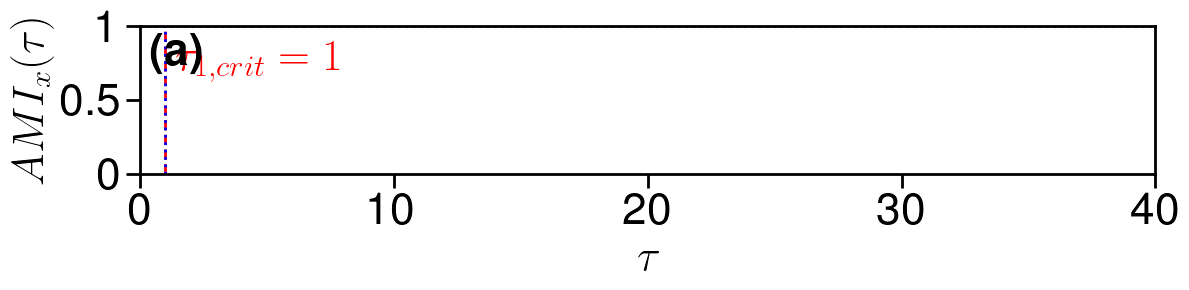

xi = 1, k = 2
Training time: 00 hours, 00 minutes, 00.038511 seconds
RAM Used: 83.9K
Num features selected (given mean FIs): 1 of 2
Training time: 00 hours, 00 minutes, 00.062018 seconds
RAM Used: 166.3K


C:\Users\AdamG\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\AdamG\AppData\Local\Temp\ipykernel_20676\4088374467.py:34: RuntimeWarning: invalid value encountered in divide
  return np.array([np.array([AMI(x[:len(x)-tau,i], x[tau:,i], bins=bins)


Total time: 00 hours, 00 minutes, 00.152046 seconds
------------------------------------------------------------------------



r=2: -----------------------------------------------------------------
(10000, 1)


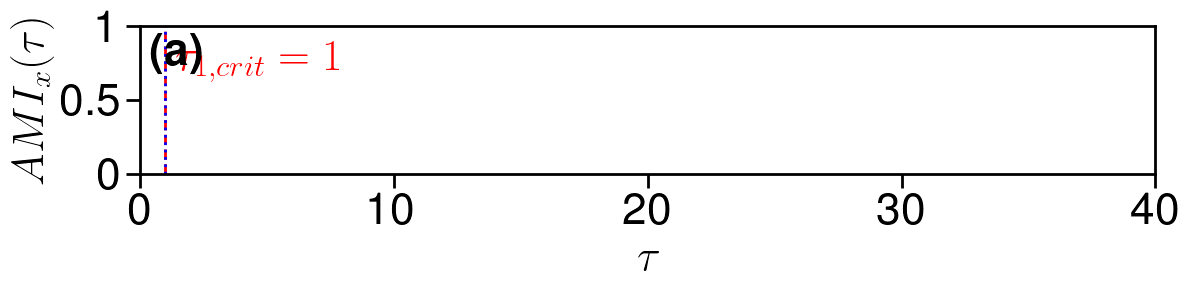

xi = 1, k = 2
Training time: 00 hours, 00 minutes, 00.035007 seconds
RAM Used: 43.2K
Num features selected (given mean FIs): 2 of 2
Training time: 00 hours, 00 minutes, 00.066519 seconds
RAM Used: 85.0K


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 00.155045 seconds
------------------------------------------------------------------------



r=3.2: -----------------------------------------------------------------
(10000, 1)


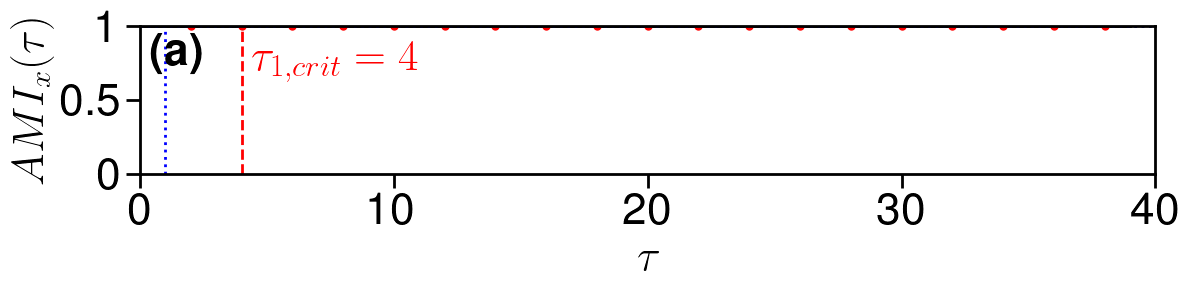

xi = 1, k = 5
Training time: 00 hours, 00 minutes, 00.038510 seconds
RAM Used: 53.4K
Num features selected (given mean FIs): 2 of 5
Training time: 00 hours, 00 minutes, 00.068018 seconds
RAM Used: 105.4K


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 00.161544 seconds
------------------------------------------------------------------------



r=3.5: -----------------------------------------------------------------
(10000, 1)


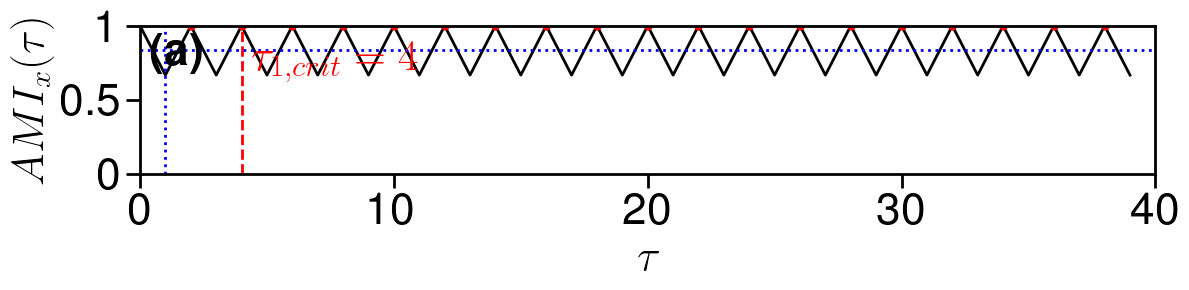

xi = 1, k = 5
Training time: 00 hours, 00 minutes, 00.039508 seconds
RAM Used: 111.3K
Num features selected (given mean FIs): 2 of 5
Training time: 00 hours, 00 minutes, 00.068016 seconds
RAM Used: 263.8K


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 00.164543 seconds
------------------------------------------------------------------------



r=3.56: -----------------------------------------------------------------
(10000, 1)


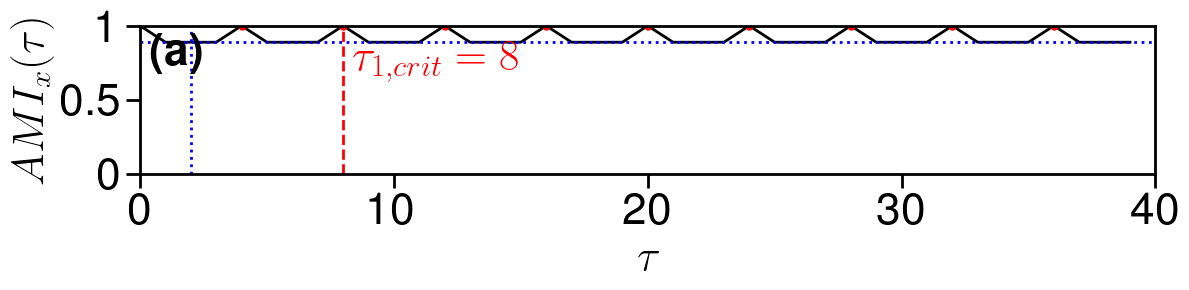

xi = 1, k = 9
Training time: 00 hours, 00 minutes, 00.040011 seconds
RAM Used: 339.5K
Num features selected (given mean FIs): 3 of 9
Training time: 00 hours, 00 minutes, 00.070520 seconds
RAM Used: 697.5K


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 00.178054 seconds
------------------------------------------------------------------------



r=3.6: -----------------------------------------------------------------
(10000, 1)


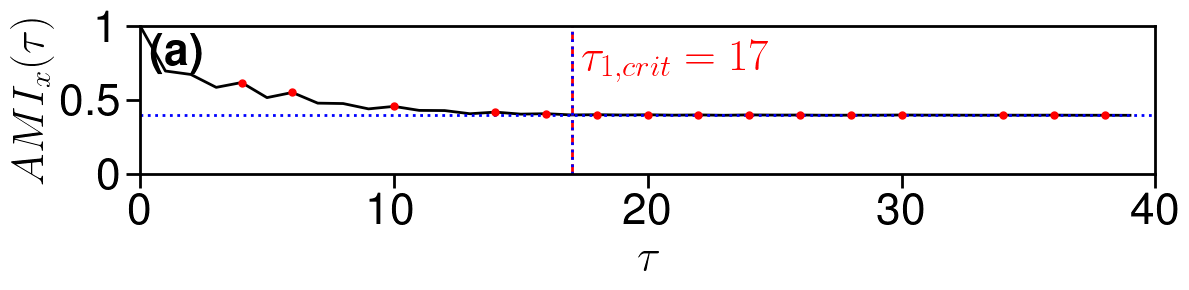

xi = 1, k = 18
Training time: 00 hours, 00 minutes, 00.136545 seconds
RAM Used: 76.1M
Num features selected (given mean FIs): 7 of 18
Training time: 00 hours, 00 minutes, 00.148547 seconds
RAM Used: 119.4M


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 00.549288 seconds
------------------------------------------------------------------------



r=3.7: -----------------------------------------------------------------
(10000, 1)


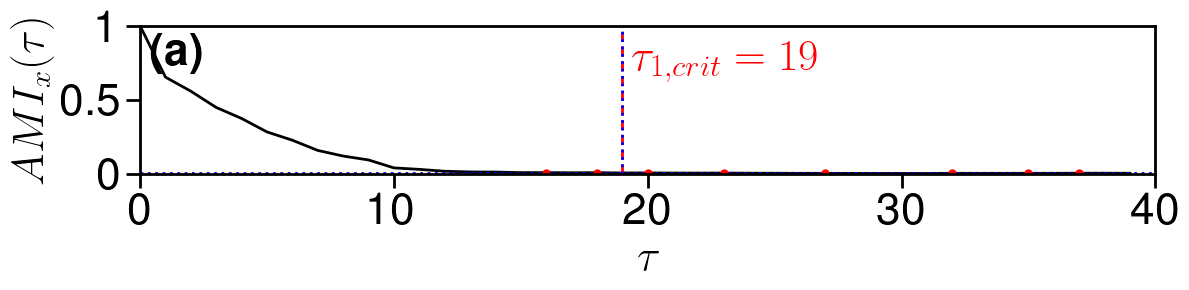

xi = 1, k = 20
Training time: 00 hours, 00 minutes, 00.166054 seconds
RAM Used: 98.2M
Num features selected (given mean FIs): 10 of 20
Training time: 00 hours, 00 minutes, 00.296386 seconds
RAM Used: 195.4M


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 01.325098 seconds
------------------------------------------------------------------------



r=3.8: -----------------------------------------------------------------
(10000, 1)


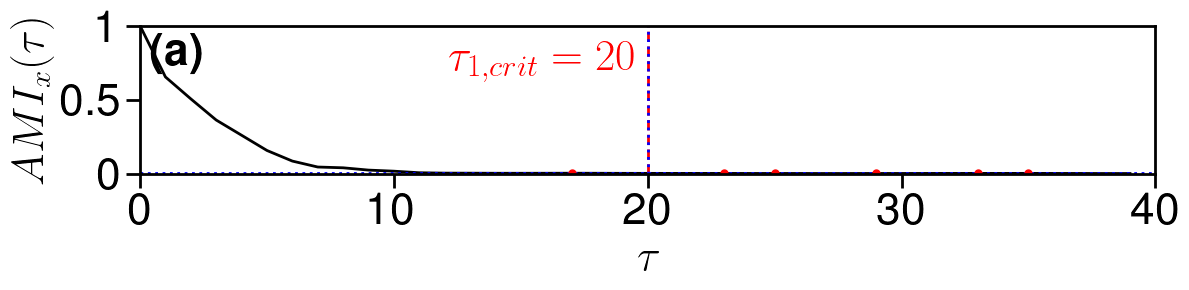

xi = 1, k = 21
Training time: 00 hours, 00 minutes, 00.170521 seconds
RAM Used: 99.0M
Num features selected (given mean FIs): 9 of 21
Training time: 00 hours, 00 minutes, 00.295084 seconds
RAM Used: 198.0M


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 01.189098 seconds
------------------------------------------------------------------------



r=3.9: -----------------------------------------------------------------
(10000, 1)


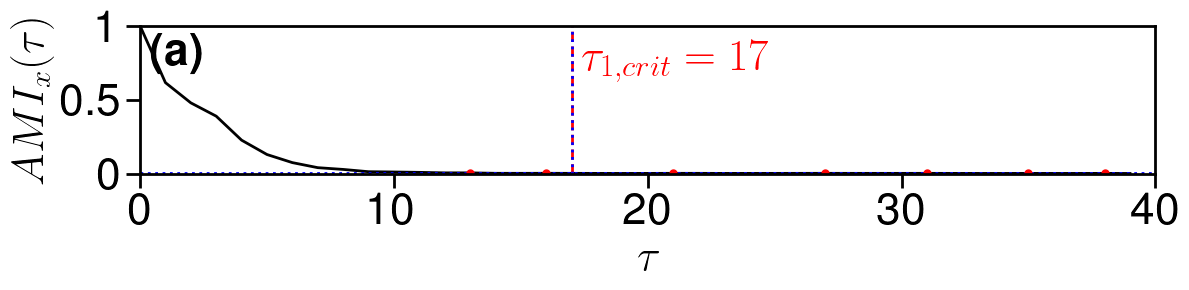

xi = 1, k = 18
Training time: 00 hours, 00 minutes, 00.161173 seconds
RAM Used: 98.9M
Num features selected (given mean FIs): 7 of 18
Training time: 00 hours, 00 minutes, 00.221634 seconds
RAM Used: 197.6M


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 00.881310 seconds
------------------------------------------------------------------------





In [152]:
rs = [0.5, 2, 3.2, 3.5, 3.56, 3.6, 3.7, 3.8, 3.9]

# x0 = 0.25 # initial x value
n_train = 10000
n_test = 1000
rm_transient = 10
# k = 20
xi = 1

pred_results, test_results = [], []

for r in tqdm(rs):
    print(f'r={r}: -----------------------------------------------------------------')
    x0 = 0.5#np.random.uniform(0,1)
    x = evolve(logistic,rm_transient + n_train + n_test + 2, x0, r=r)
    x = x.reshape(-1,1)
    
    X_train, y_train = lead_data(x[rm_transient:rm_transient+n_train+1,:])
    X_test, y_test = lead_data(x[rm_transient+n_train+1:,:])
    
    print(X_train.shape)
    
    tau_crits = get_tau_crits(X_train, p_val=0.5, max_lag=40, make_plot=True, incorporate_peaks=True)
    k = int(np.ceil(max(tau_crits)/xi + 1))
    print(f'xi = {xi}, k = {k}')
    
    features, labels = make_features_and_labels(X_train, k, xi=xi, stride=1, lead=1)
    
    FIs, ETR1, time_elapsed = feature_selection(features, labels, n_estimators=100, max_depth=None, random_state=None,
                                                n_jobs=-1, n_samples=None, model_type='ETR', verbose=True,
                                                return_model=True)
    all_FIs = np.array([tree.feature_importances_ for tree in ETR1.estimators_])
    
    s = None#y_train[-k*xi:len(y_train)].T.flatten()
    y_pred_TreeDOX, model, time_elapsed = future_prediction(features, labels, all_FIs,
                                                            len(y_test), p=None, xi=xi,
                                                            n_estimators=200,
                                                            disp_progress=True,
                                                            desc='',
                                                            max_depth=None,
                                                            random_state=None,
                                                            n_jobs=-1,
                                                            min_samples_split=2,
                                                            min_samples_leaf=1,
                                                            ccp_alpha=0,
                                                            max_features=1.0,
                                                            n_samples=None,
                                                            model=None, s=s,
                                                            model_type='ETR',
                                                            verbose=False,
                                                            model_conversion=None,
                                                            device='cuda')
    
    pred_results += [y_pred_TreeDOX]
    test_results += [y_test]
    print('------------------------------------------------------------------------\n\n\n')

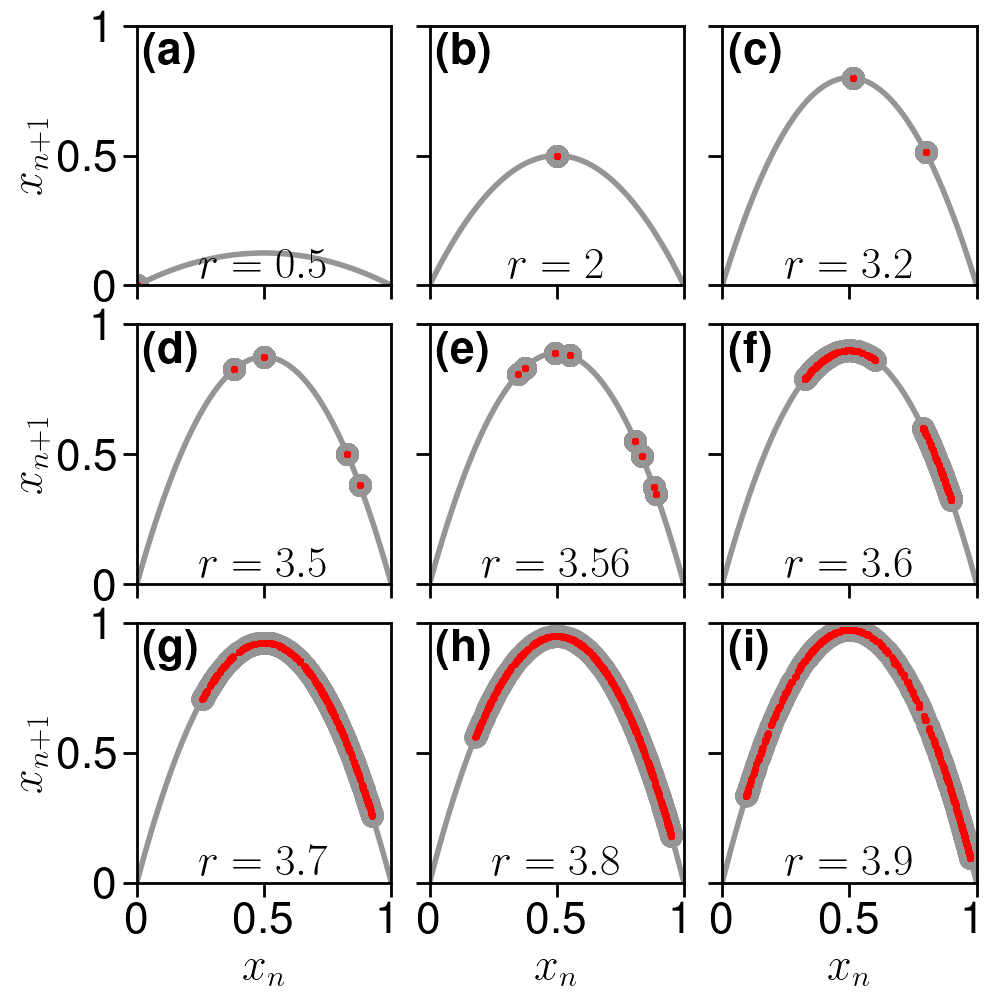

In [154]:
fig, axs = plt.subplots(3,3,sharex=True,sharey=True,figsize=(10,10))

fontsize = 32

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

lw = 4
ms = 15
ms_pred = 4

plt.xlim([0,1])
plt.ylim([0,1])

axs = axs.flatten()


for i in range(len(rs)):
    ax = axs[i]
    y_test = test_results[i]
    y_pred = pred_results[i]

#     ax.grid()

    if i in [0,3,6]:
        ax.set_ylabel('$x_{n+1}$',fontsize=fontsize,fontproperties=prop)

    if i in [6,7,8]:
        ax.set_xlabel('$x_n$',fontsize=fontsize)

    lab = [0,0.5,1]
    ax.set_xticks(lab)
    ax.set_yticks(lab)
    ax.set_xticklabels([str(i) for i in lab])
    ax.set_yticklabels([str(i) for i in lab])


#     if i == 0 or i == 3:
#         ax.set_yticks([0.2,0.4,0.6,0.8,1])
#     elif i == 6:
#         ax.set_yticks([0,0.2,0.4,0.6,0.8])
#     elif i == 7:
#         ax.set_xticks([0.2,0.4,0.6,0.8])

    x_plt = np.linspace(0,1,100)
    ax.plot(x_plt,rs[i]*x_plt*(1-x_plt),c=np.array([1,1,1])*150/256,lw=lw)

    ax.plot(y_test[:-1],y_test[1:],'o',c=np.array([1,1,1])*150/256,ms=ms)
    ax.plot(y_pred[:-1],y_pred[1:],'ro',ms=ms_pred)

#     ax.text(0.025,0.91,r'$r='+str(rs[i])+r'$',fontsize=fontsize)
    # ax.text(0.5,0.025,r'$r='+str(rs[i])+r'$',ha='center',fontsize=fontsize)
    ax.annotate(r'$r='+str(rs[i])+r'$',xy=(0.5,0.025),ha='center',fontsize=fontsize,fontproperties=prop)



# plt.supxlabel('$x_n$',fontsize=18)
# plt.supylabel('$x_{n+1}$',fontsize=18)
plt.tight_layout()
plt.subplots_adjust(hspace=0.15,wspace=0.15)
fig.align_labels([axs])

for i in range(len(rs)):
    plt.setp(axs[i].spines.values(), linewidth=2)
    axs[i].tick_params(length=10,width=2)
    axs[i].annotate(r'\textbf{('+chr(97+i)+')}', xy=(0.025,0.975), ha='left', va='top', fontsize=fontsize)


# plt.subplots_adjust(wspace=0.1, hspace=0.1)

# plt.title('Logistic Map Bifurcation',fontsize=18)
title = 'Logistic_Map_Recreated_Dynamics'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()
plt.close(fig)

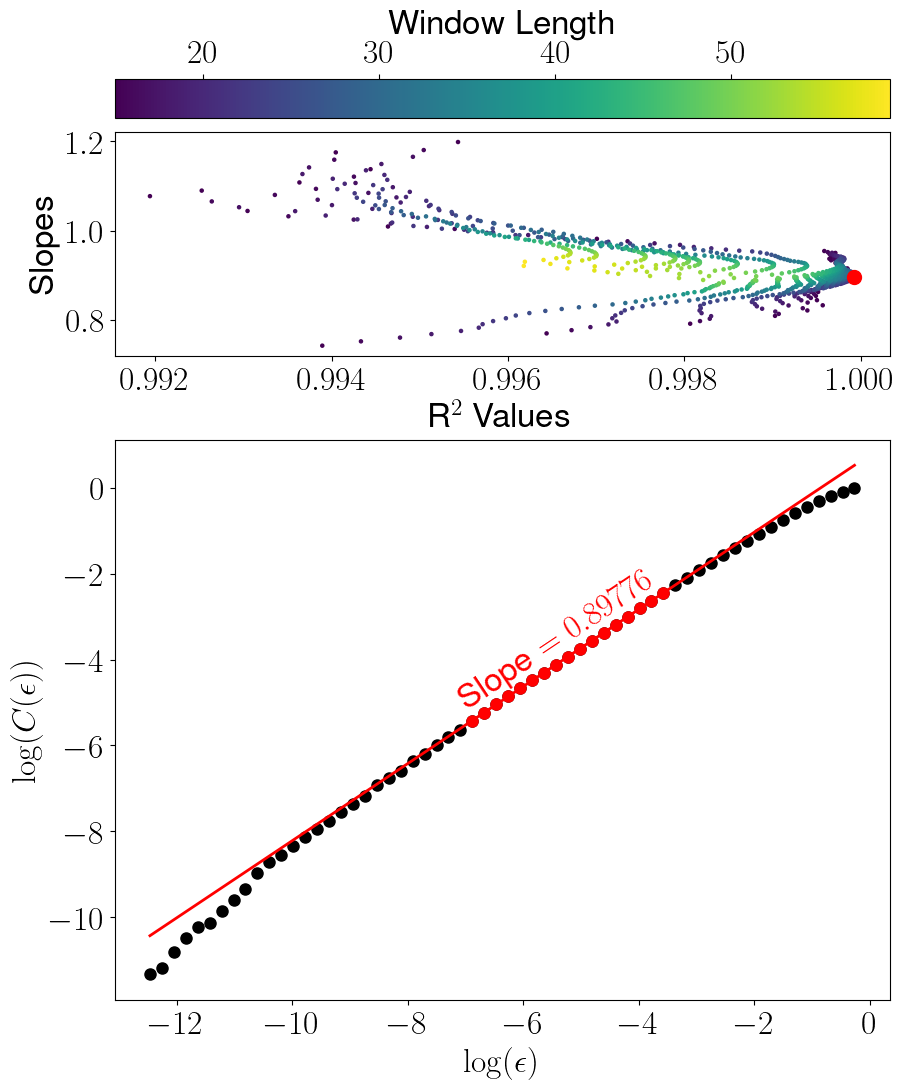

0.8977629822363167


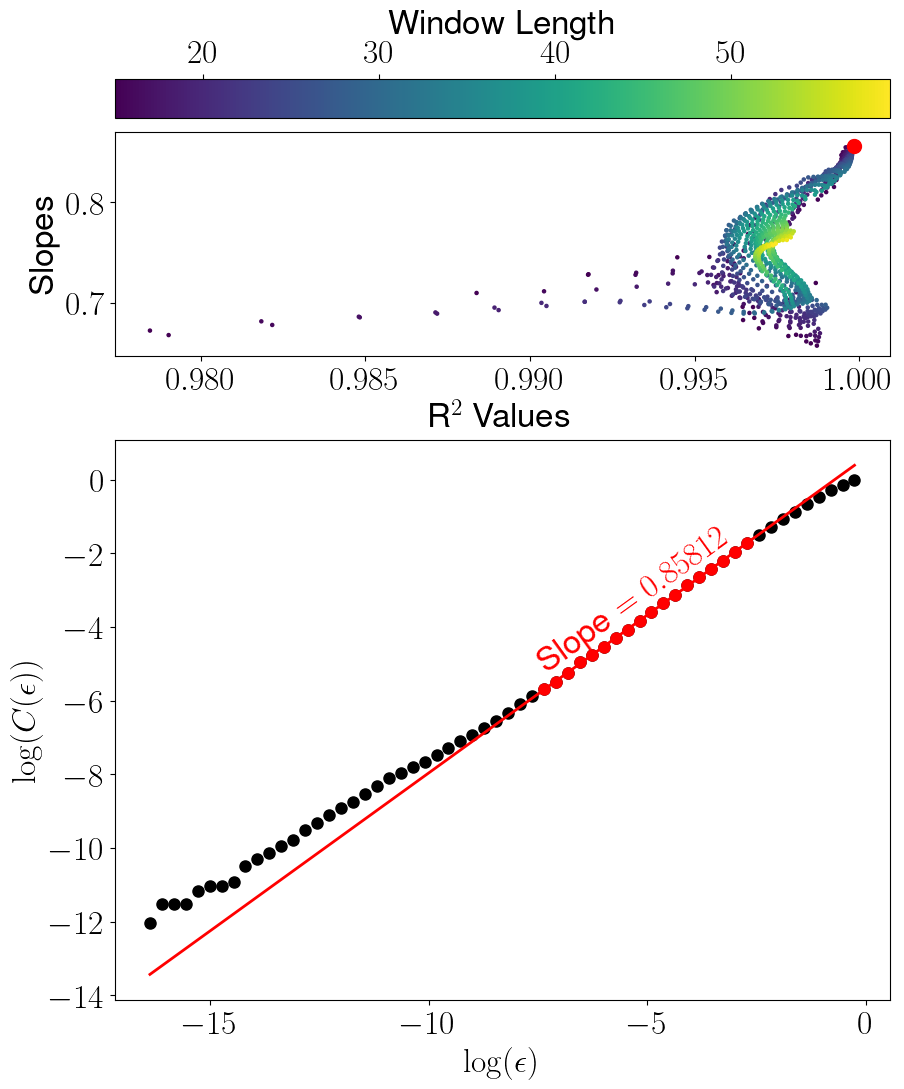

0.8581235518318369


In [87]:
i = 7
corrdim_test = correlation_dimension(test_results[i], num=60, lims=None, remove_pval=0.05, 
                                     mode='highest_r2',
                                     param=15, debug_plots=True, debug_data=False)
print(corrdim_test)

corrdim_pred_TreeDOX = correlation_dimension(pred_results[i], num=60, lims=None, remove_pval=0.05, 
                                             mode='highest_r2',
                                             param=15, debug_plots=True, debug_data=False)
print(corrdim_pred_TreeDOX)

# Recreating Bifurcation Diagram

In [ ]:
n_samples = 100
rs = np.linspace(2.75,4,n_samples)

# x0 = 0.25 # initial x value
n_train = 250
n_test = 250
rm_transient = 10
k = 20
xi = 1

results = np.zeros((n_samples,2))

for i, r in enumerate(tqdm(rs)):
    x = evolve(logistic,rm_transient + n_train + n_test + 2, np.random.uniform(low=0,high=1), r=r)
    x = x.reshape(-1,1)
    
    X_train, y_train = lead_data(x[rm_transient:rm_transient+n_train+1,:])
    X_test, y_test = lead_data(x[rm_transient+n_train+1:,:])
    
    features, labels = make_features_and_labels(X_train, k, xi=xi, stride=1, lead=1)
    
    FIs, time_elapsed = feature_selection(features, labels, n_estimators=10, max_depth=None, random_state=None,
                                          n_jobs=-1, n_samples=None, model_type='ETR', verbose=False)
    
    s = y_train[-k*xi:len(y_train)].T.flatten()
    y_pred_TreeDOX, model, time_elapsed = future_prediction(features, labels, FIs,
                                                            len(y_test), p=None, xi=xi,
                                                            n_estimators=25,
                                                            disp_progress=False,
                                                            desc='',
                                                            max_depth=None,
                                                            random_state=None,
                                                            n_jobs=-1,
                                                            min_samples_split=2,
                                                            min_samples_leaf=1,
                                                            ccp_alpha=0,
                                                            max_features=0.5,
                                                            n_samples=None,
                                                            model=None, s=s,
                                                            model_type='ETR',
                                                            verbose=False,
                                                            model_conversion=None,
                                                            device='cuda')
    
    results[i,:] = y_test[-1,0], y_pred_TreeDOX[-1,0]

In [46]:
import glob

r_chaos = 3.5699456

collect_results = True

if collect_results:
    fnames = [fname.split('\\')[-1] for fname in glob.glob(data_dir + 'logistic_bifurcation_predicted*') if 'final' not in fname]
    for i, fname in enumerate(fnames):
        print(f'Reading {fname}')
        if i == 0:
            with gzip.open(data_dir + fname, 'rb') as file:
                fixed_pt_pred = pkl.load(file)
        else:
            with gzip.open(data_dir + fname, 'rb') as file:
                fixed_pt_pred = np.vstack((fixed_pt_pred,pkl.load(file)))
                
    fixed_pt_pred = fixed_pt_pred[fixed_pt_pred[:, 0].argsort()]
    
    with gzip.open(data_dir + 'logistic_bifurcation_predicted_final.data', 'wb') as file:
        pkl.dump(fixed_pt_pred,file)
else:
    with gzip.open(data_dir + 'logistic_bifurcation_predicted_final.data', 'rb') as file:
            fixed_pt_pred = pkl.load(file)

if collect_results:
    fnames = [fname.split('\\')[-1] for fname in glob.glob(data_dir + 'logistic_bifurcation_test*') if 'final' not in fname]
    for i, fname in enumerate(fnames):
        print(f'Reading {fname}')
        if i == 0:
            with gzip.open(data_dir + fname, 'rb') as file:
                fixed_pt_test = pkl.load(file)
        else:
            with gzip.open(data_dir + fname, 'rb') as file:
                fixed_pt_test = np.vstack((fixed_pt_test,pkl.load(file)))
                
    fixed_pt_test = fixed_pt_test[fixed_pt_test[:, 0].argsort()]
    
    with gzip.open(data_dir + 'logistic_bifurcation_test_final.data', 'wb') as file:
        pkl.dump(fixed_pt_test,file)
else:
    with gzip.open(data_dir + 'logistic_bifurcation_test_final.data', 'rb') as file:
            fixed_pt_test = pkl.load(file)
            
# with gzip.open(data_dir + 'logistic_bifurcation_true.data','rb') as file:
#     r_vals = pkl.load(file) 
#     fixed_pt_test = pkl.load(file)
#     fixed_pt_test = np.vstack((r_vals, fixed_pt_test)).T

Reading logistic_bifurcation_predicted_chaos1.data
Reading logistic_bifurcation_predicted_chaos10.data
Reading logistic_bifurcation_predicted_chaos11.data
Reading logistic_bifurcation_predicted_chaos12.data
Reading logistic_bifurcation_predicted_chaos13.data
Reading logistic_bifurcation_predicted_chaos14.data
Reading logistic_bifurcation_predicted_chaos15.data
Reading logistic_bifurcation_predicted_chaos16.data
Reading logistic_bifurcation_predicted_chaos17.data
Reading logistic_bifurcation_predicted_chaos18.data
Reading logistic_bifurcation_predicted_chaos19.data
Reading logistic_bifurcation_predicted_chaos2.data
Reading logistic_bifurcation_predicted_chaos20.data
Reading logistic_bifurcation_predicted_chaos21.data
Reading logistic_bifurcation_predicted_chaos22.data
Reading logistic_bifurcation_predicted_chaos23.data
Reading logistic_bifurcation_predicted_chaos24.data
Reading logistic_bifurcation_predicted_chaos25.data
Reading logistic_bifurcation_predicted_chaos26.data
Reading logist

In [47]:
fixed_pt_pred.shape, fixed_pt_test.shape

((1600000, 2), (1600000, 2))

In [29]:
print(fixed_pt_pred[fixed_pt_pred[:,0]<=r_chaos].shape, fixed_pt_pred[fixed_pt_pred[:,0]>=r_chaos].shape)
print(fixed_pt_test[fixed_pt_test[:,0]<=r_chaos].shape, fixed_pt_test[fixed_pt_test[:,0]>=r_chaos].shape)

(100434, 2) (850005, 2)
(8924864, 2) (1075136, 2)


In [30]:
prop_nc_pred = fixed_pt_pred[fixed_pt_pred[:,0]<=r_chaos].shape[0]/fixed_pt_pred.shape[0]
prop_nc_test = fixed_pt_test[fixed_pt_test[:,0]<=r_chaos].shape[0]/fixed_pt_test.shape[0]
print(prop_nc_pred, prop_nc_test)

interp_r = np.linspace(np.min(fixed_pt_test[:,0]), r_chaos, round((1-prop_nc_test)*fixed_pt_test.shape[0]*prop_nc_pred/(1-prop_nc_pred)))
# interp_x = np.interp(interp_r, fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][:,0], fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][:,1])
f = sp.interpolate.interp1d(fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][:,0], fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][:,1],
                            kind='nearest', bounds_error=False, fill_value='extrapolate')
interp_x = f(interp_r)

fixed_pt_test_interp = np.vstack((np.vstack((interp_r,interp_x)).T, fixed_pt_test[fixed_pt_test[:,0]>=r_chaos]))
fixed_pt_test_interp.shape, fixed_pt_test_interp[fixed_pt_test_interp[:,0]<=r_chaos].shape[0]/fixed_pt_test_interp.shape[0]

0.10567550505050505 0.8924864


((1202177, 2), 0.10567578651063862)

In [31]:
print(fixed_pt_pred.shape, fixed_pt_test_interp.shape)

(950400, 2) (1202177, 2)


In [32]:
with gzip.open(data_dir + 'logistic_bifurcation_true_reduced_filesize.data', 'wb') as file:
    pkl.dump(fixed_pt_test_interp, file)

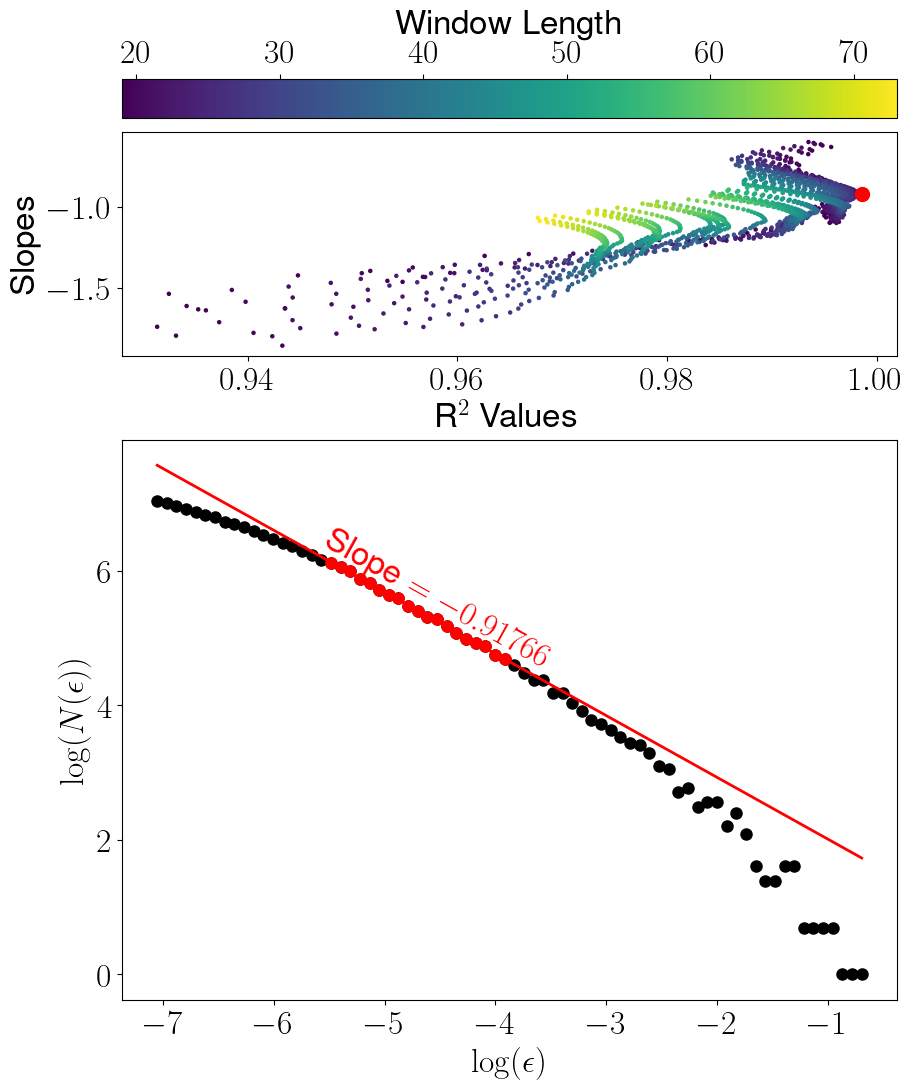

0.9176597580533421


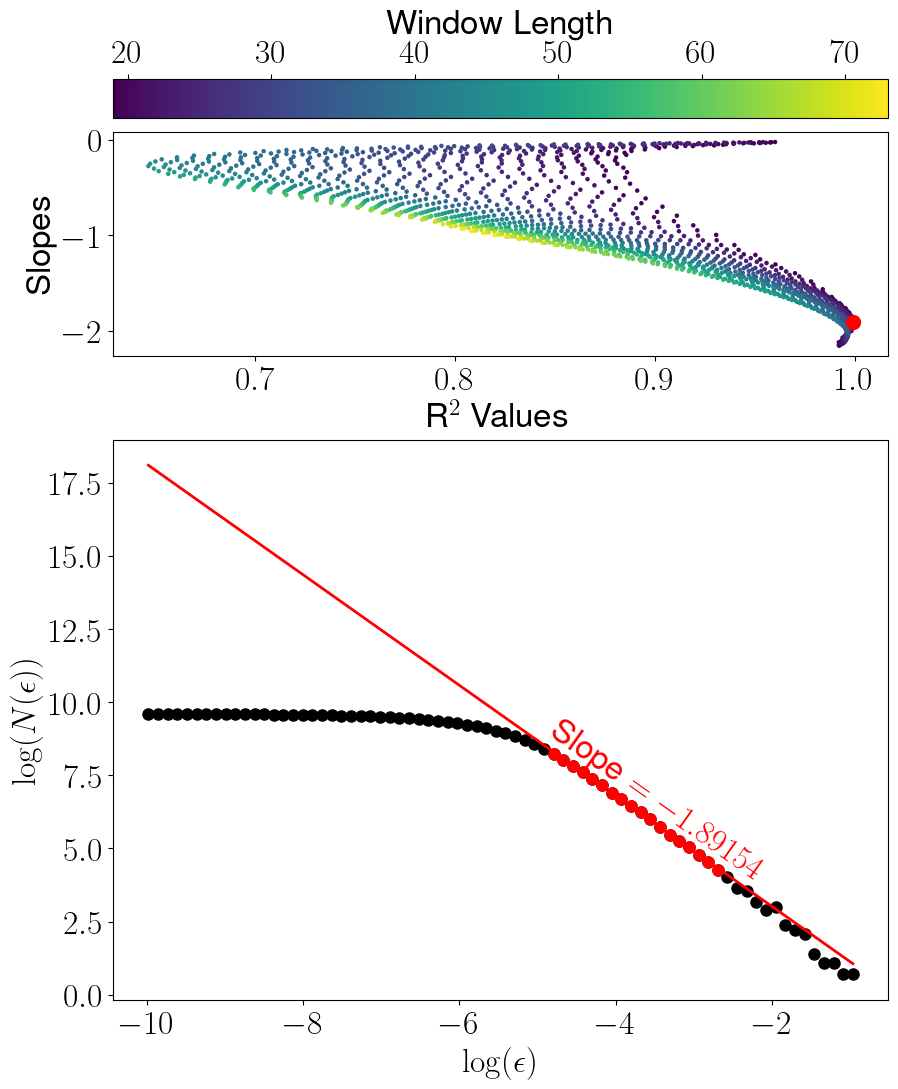

1.8915372390384937


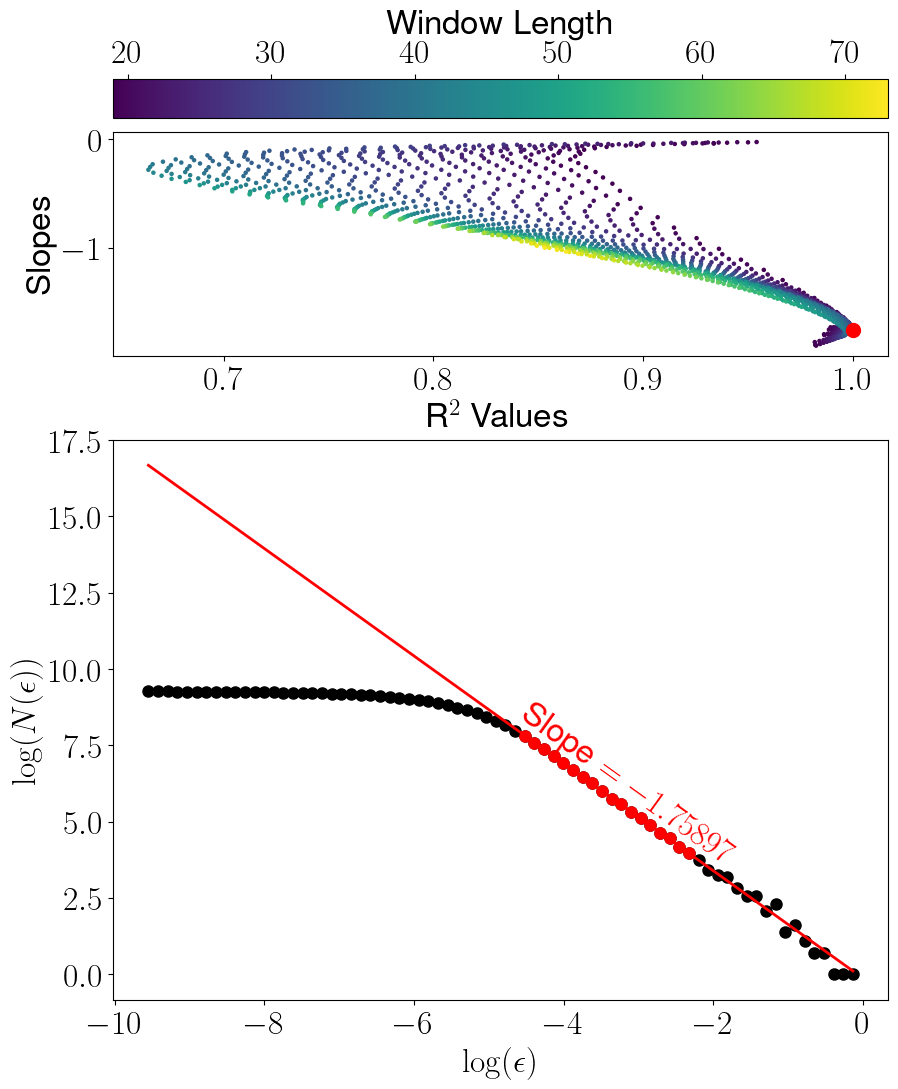

1.75897357220504


In [50]:
hausdorff_dims_test = []

# pre-chaos
hausdorff_test_nc = hausdorff_dimension(fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][::75], num=75, lims=None, remove_pval=0.05, 
                                        mode='highest_r2',
                                        param=0.25, debug_plots=True, debug_data=False)
hausdorff_dims_test.append(hausdorff_test_nc)
print(hausdorff_test_nc)

# post-chaos
hausdorff_test_c = hausdorff_dimension(fixed_pt_test[fixed_pt_test[:,0]>=r_chaos][::100], num=75, lims=None, remove_pval=0.05, 
                                       mode='highest_r2',
                                       param=0.25, debug_plots=True, debug_data=False)
hausdorff_dims_test.append(hausdorff_test_c)
print(hausdorff_test_c)

# all
hausdorff_test_all = hausdorff_dimension(fixed_pt_test[::150], num=75, lims=None, remove_pval=0.05, 
                                         mode='highest_r2',
                                         param=0.25, debug_plots=True, debug_data=False)
hausdorff_dims_test.append(hausdorff_test_all)
print(hausdorff_test_all)

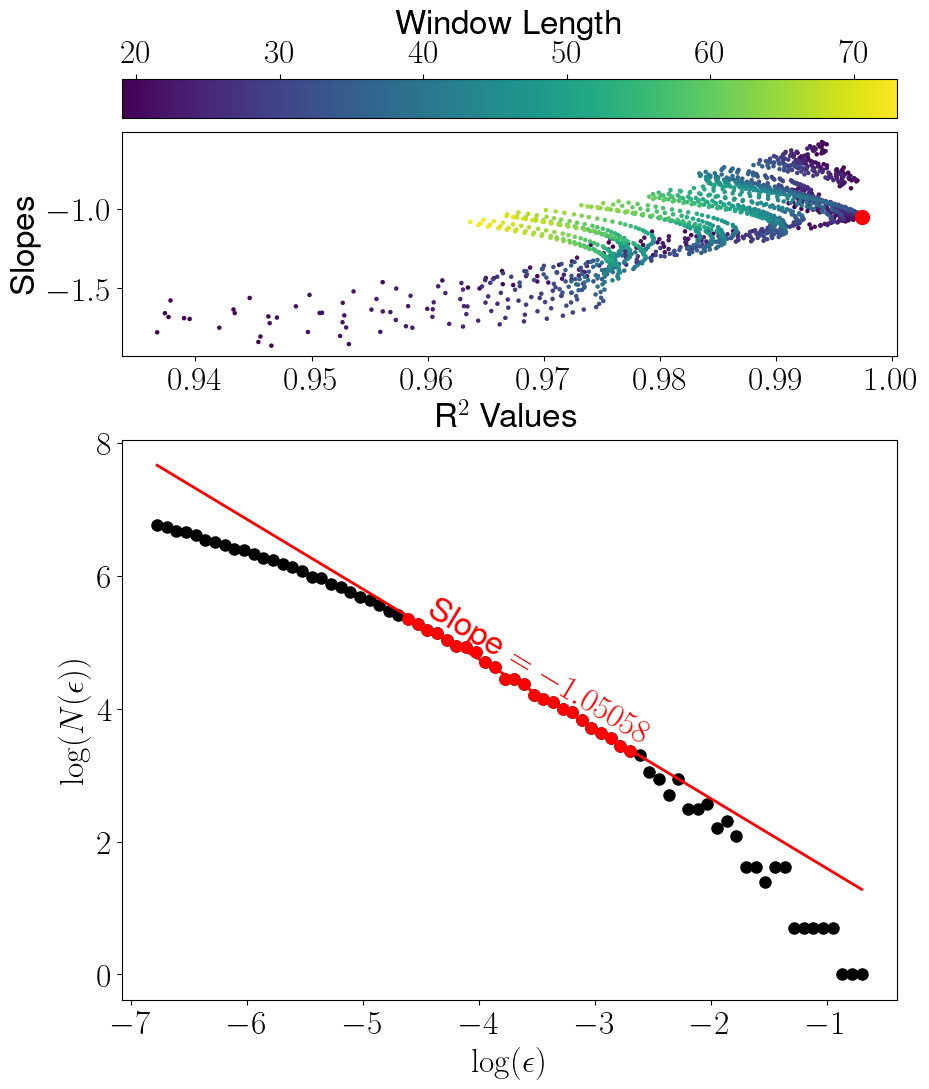

1.0505796771007319


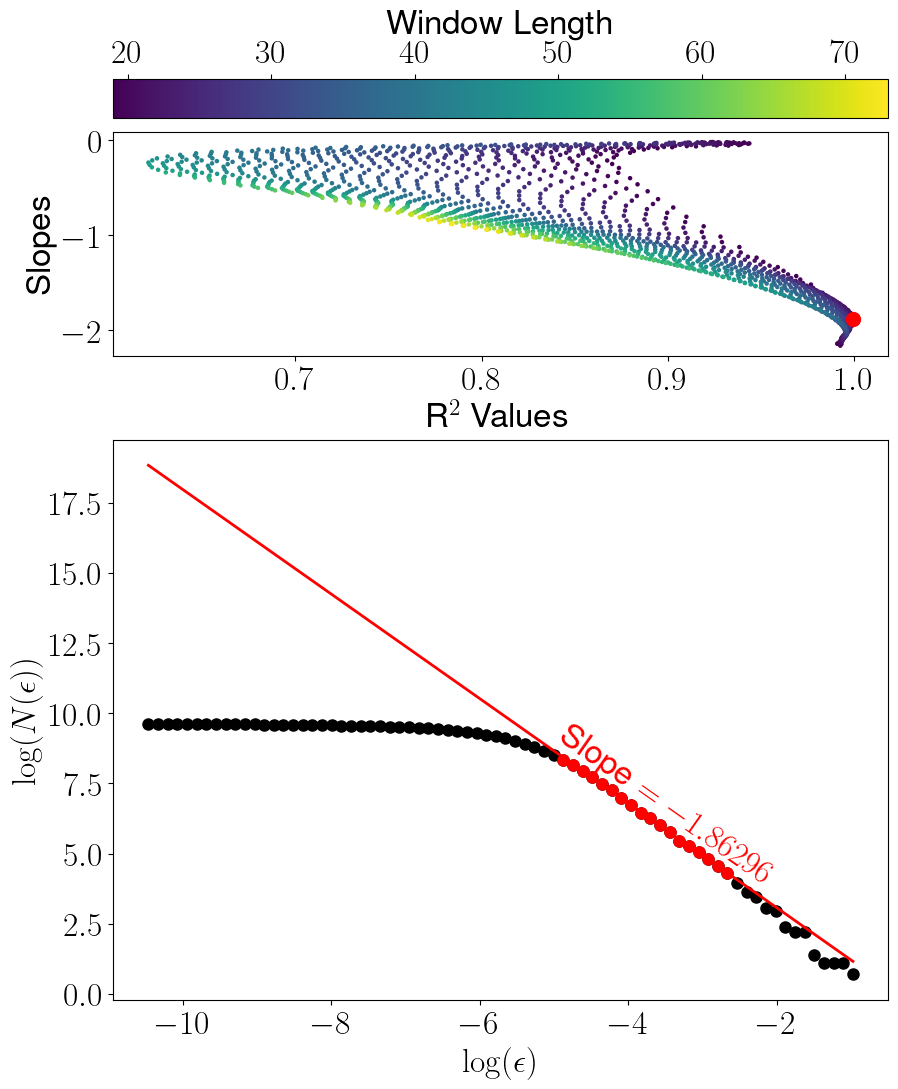

1.8629590370626439


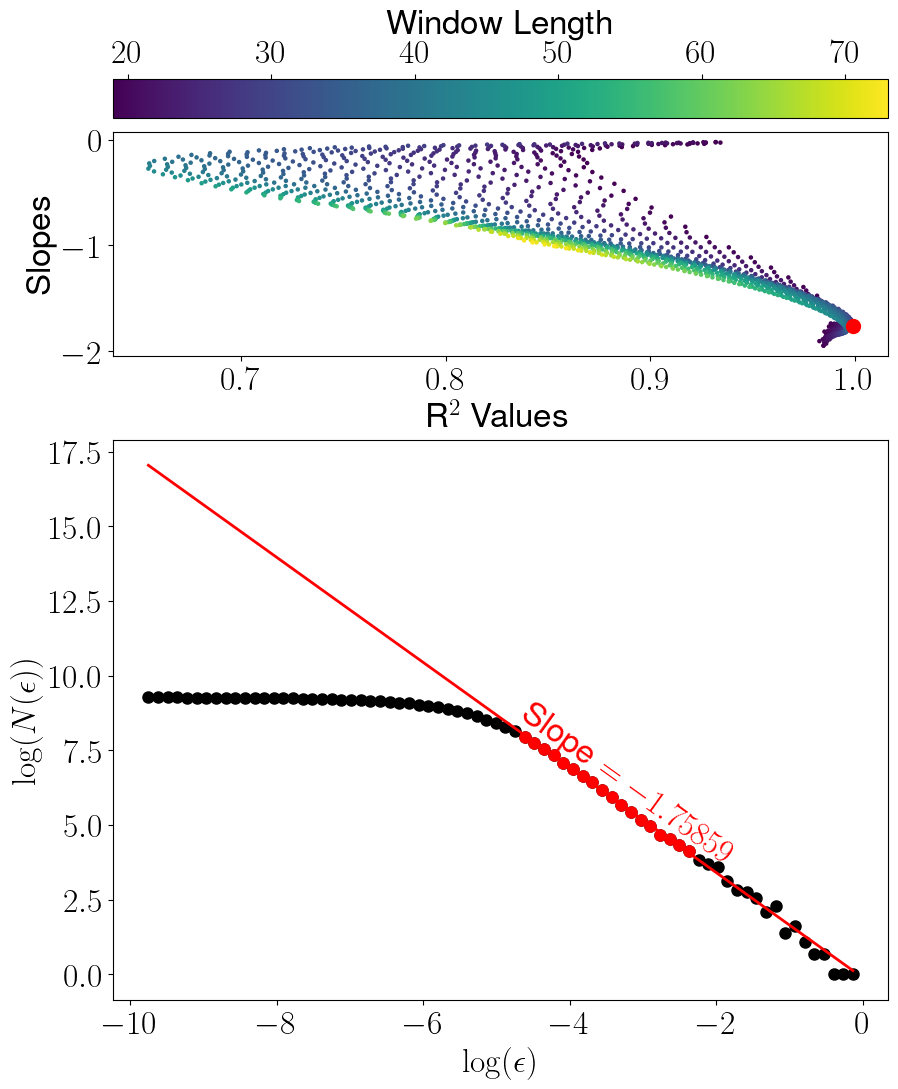

1.758594451687339


In [51]:
hausdorff_dims_pred = []

# pre-chaos
hausdorff_pred_nc = hausdorff_dimension(fixed_pt_pred[fixed_pt_pred[:,0]<=r_chaos][::100], num=75, lims=None, remove_pval=0.05, 
                                        mode='highest_r2',
                                        param=0.25, debug_plots=True, debug_data=False)
hausdorff_dims_pred.append(hausdorff_pred_nc)
print(hausdorff_pred_nc)

# post-chaos
hausdorff_pred_c = hausdorff_dimension(fixed_pt_pred[fixed_pt_pred[:,0]>=r_chaos][::100], num=75, lims=None, remove_pval=0.05, 
                                       mode='highest_r2',
                                       param=0.25, debug_plots=True, debug_data=False)
hausdorff_dims_pred.append(hausdorff_pred_c)
print(hausdorff_pred_c)

# all
hausdorff_pred_all = hausdorff_dimension(fixed_pt_pred[::150], num=75, lims=None, remove_pval=0.05, 
                                         mode='highest_r2',
                                         param=0.25, debug_plots=True, debug_data=False)
hausdorff_dims_pred.append(hausdorff_pred_all)
print(hausdorff_pred_all)

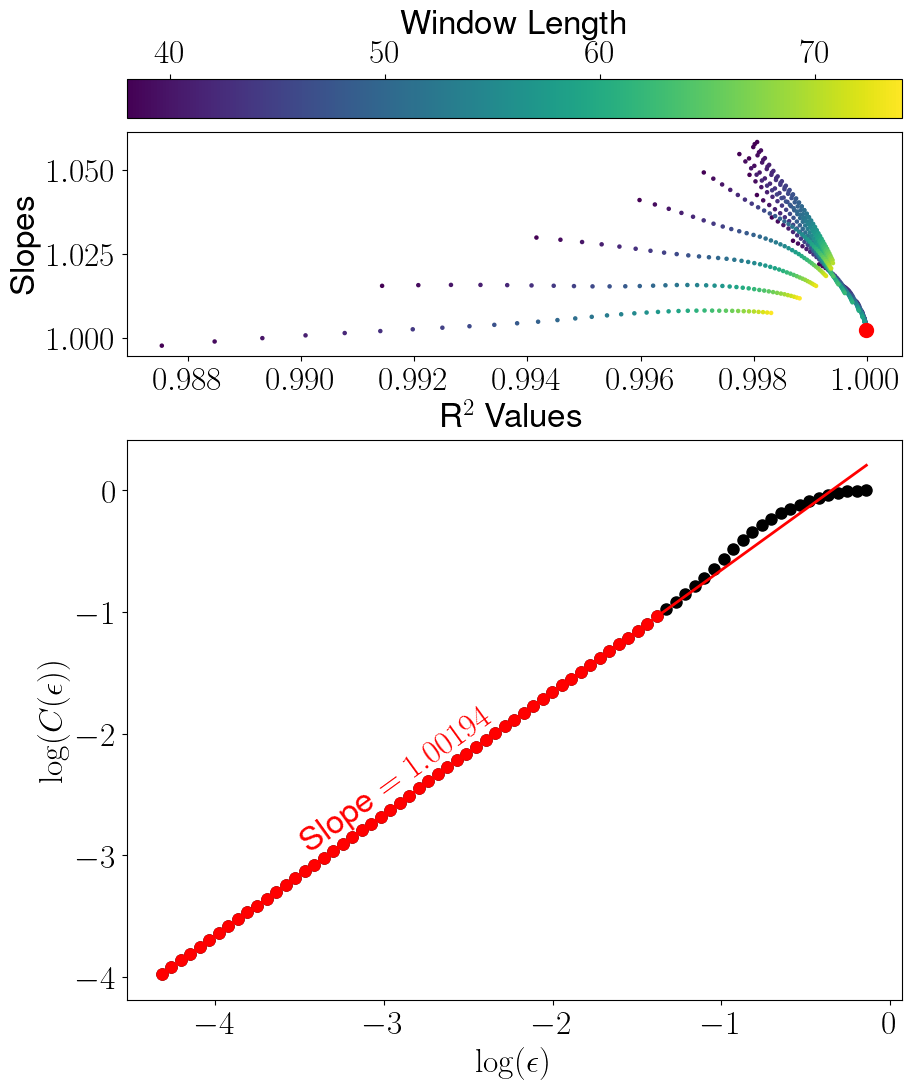

1.0019402800336592


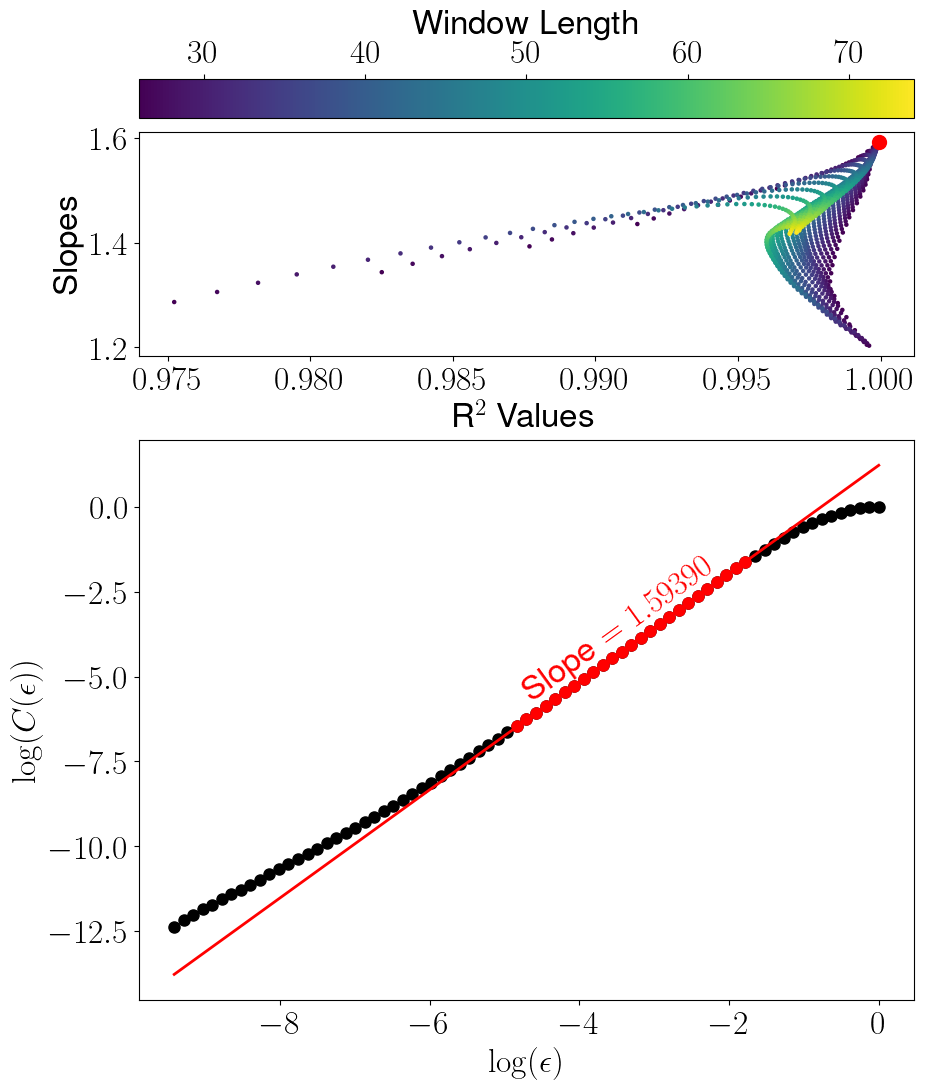

1.5938982667634276


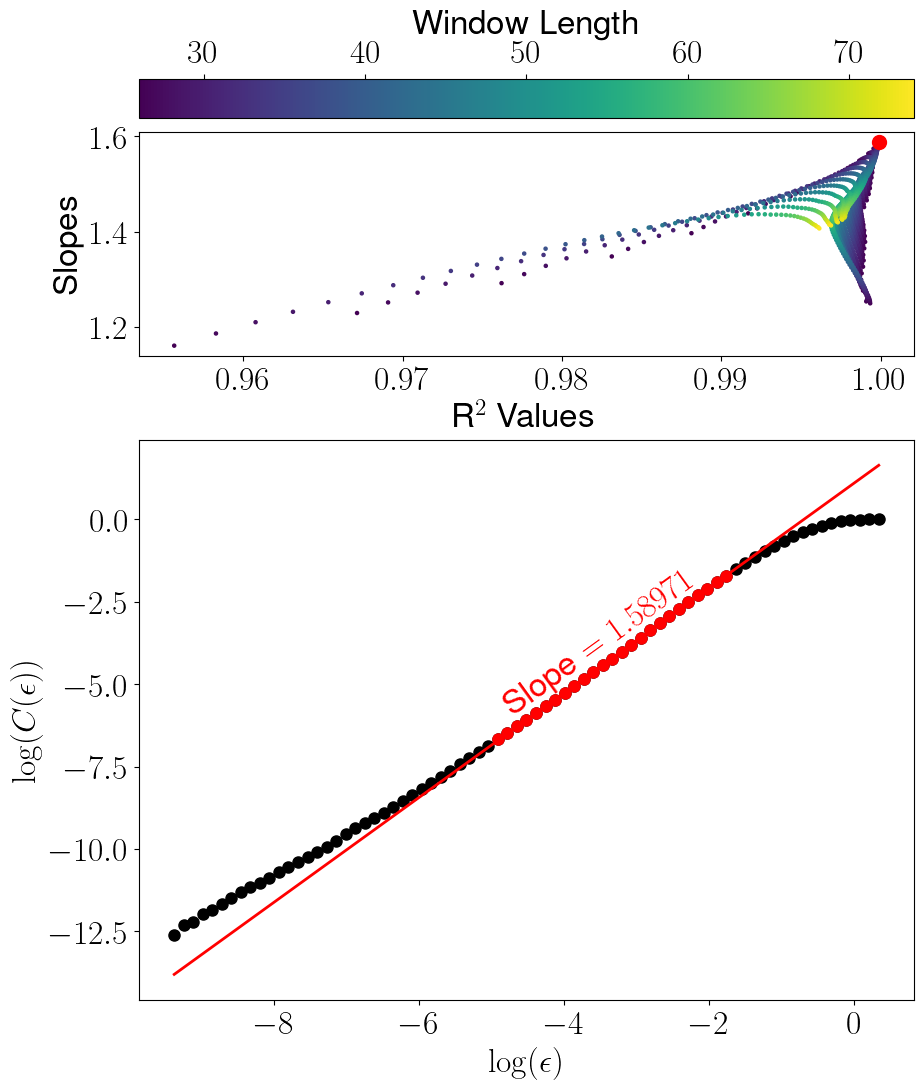

1.5897130542896305


In [59]:
correlation_dims_test = []

# pre-chaos
correlation_test_nc = correlation_dimension(fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][::25], num=75, lims=None, remove_pval=0.5, 
                                        mode='highest_r2',
                                        param=0.5, debug_plots=True, debug_data=False)
# correlation_test_nc = correlation_dimension(fixed_pt_test_interp[fixed_pt_test_interp[:,0]<=r_chaos][::100], num=75, lims=None, remove_pval=0.1, 
#                                         mode='highest_r2',
#                                         param=0.25, debug_plots=True, debug_data=False)
correlation_dims_test.append(correlation_test_nc)
print(correlation_test_nc)

# post-chaos
correlation_test_c = correlation_dimension(fixed_pt_test[fixed_pt_test[:,0]>=r_chaos][::100], num=75, lims=None, remove_pval=0.1, 
                                       mode='highest_r2',
                                       param=0.35, debug_plots=True, debug_data=False)
correlation_dims_test.append(correlation_test_c)
print(correlation_test_c)

# all
correlation_test_all = correlation_dimension(fixed_pt_test[::100], num=75, lims=None, remove_pval=0.1, 
                                         mode='highest_r2',
                                         param=0.35, debug_plots=True, debug_data=False)
correlation_dims_test.append(correlation_test_all)
print(correlation_test_all)

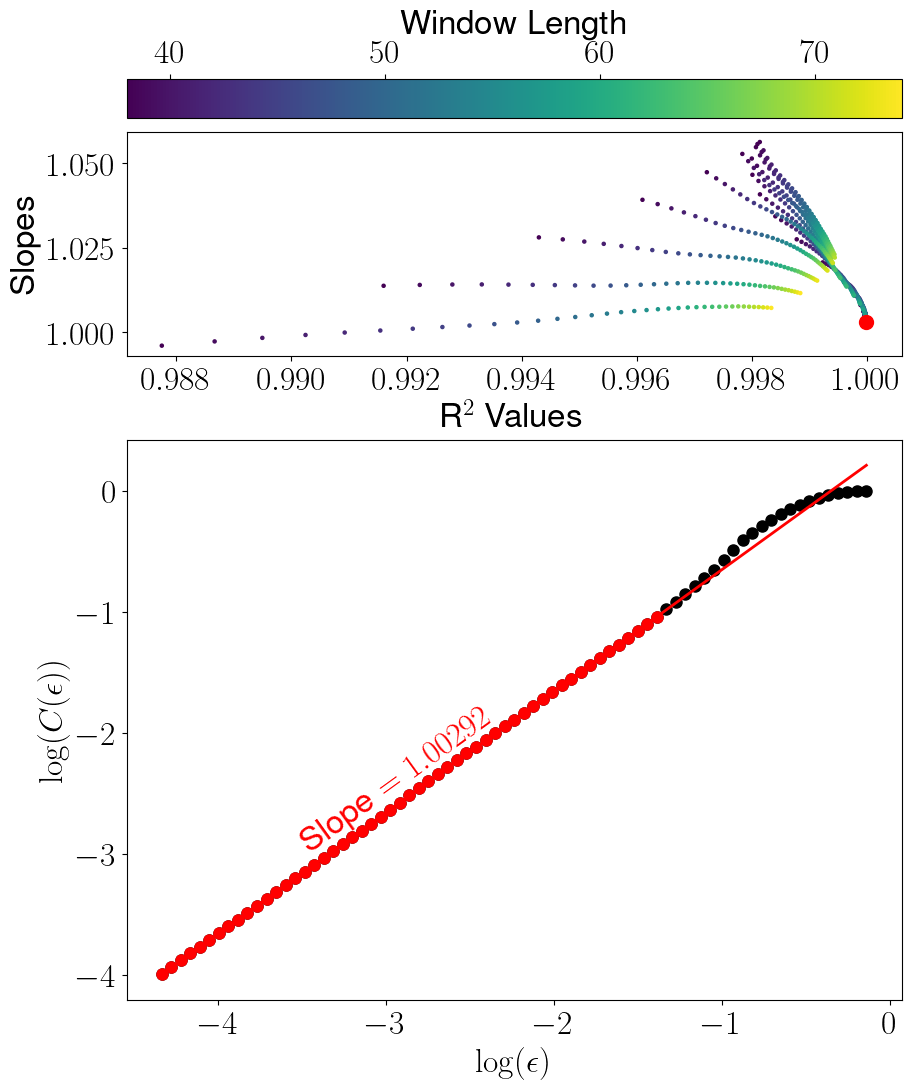

1.0029168392017995


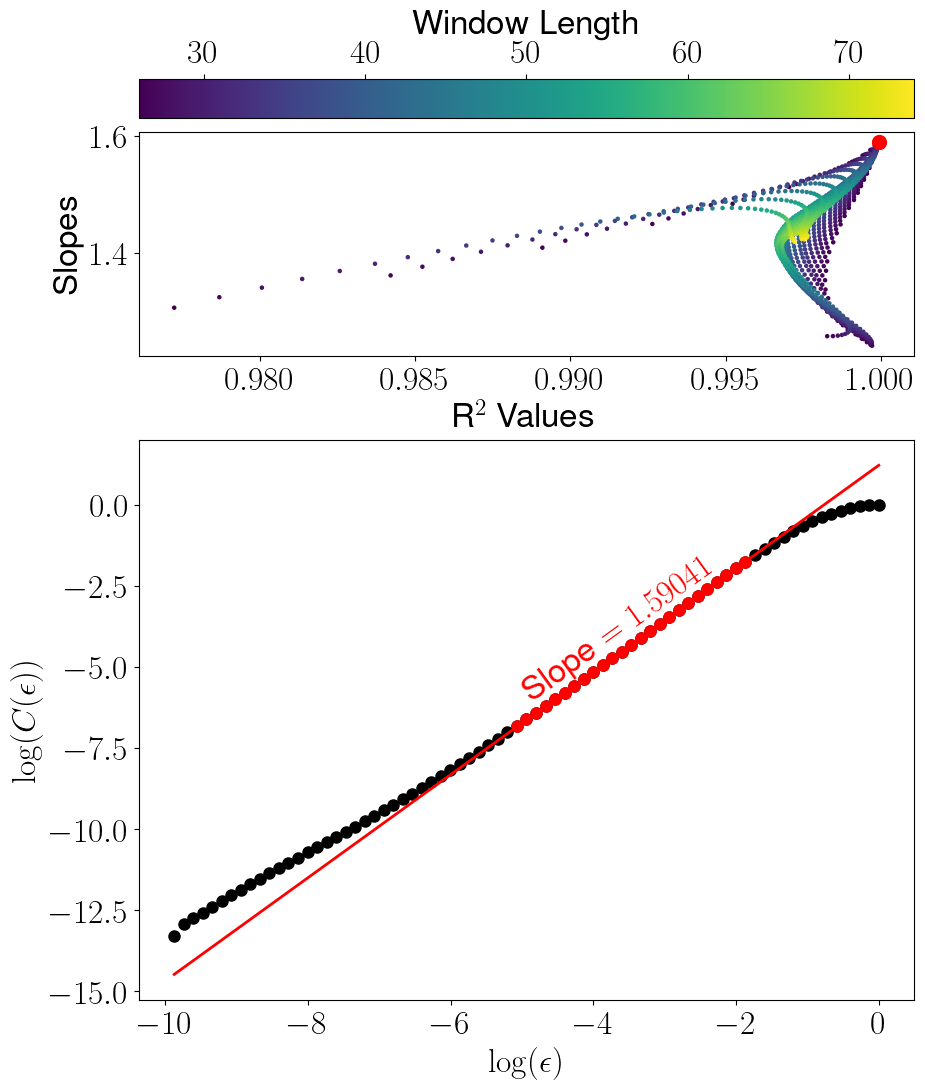

1.590408726752416


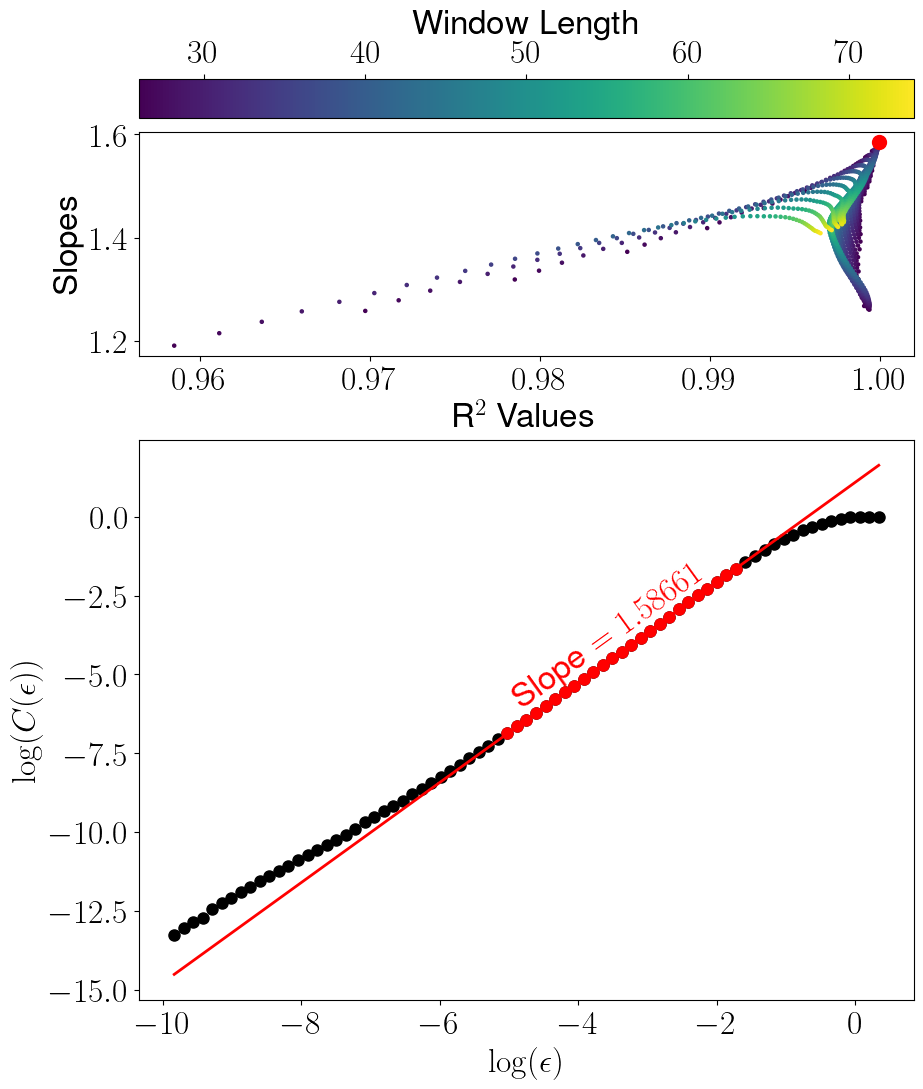

1.5866064057323106


In [62]:
correlation_dims_pred = []

# pre-chaos
correlation_pred_nc = correlation_dimension(fixed_pt_pred[fixed_pt_pred[:,0]<=r_chaos][::25], num=75, lims=None, remove_pval=0.5, 
                                        mode='highest_r2',
                                        param=0.5, debug_plots=True, debug_data=False)
correlation_dims_pred.append(correlation_pred_nc)
print(correlation_pred_nc)

# post-chaos
correlation_pred_c = correlation_dimension(fixed_pt_pred[fixed_pt_pred[:,0]>=r_chaos][::100], num=75, lims=None, remove_pval=0.1, 
                                       mode='highest_r2',
                                       param=0.35, debug_plots=True, debug_data=False)
correlation_dims_pred.append(correlation_pred_c)
print(correlation_pred_c)

# all
correlation_pred_all = correlation_dimension(fixed_pt_pred[::100], num=75, lims=None, remove_pval=0.1, 
                                         mode='highest_r2',
                                         param=0.35, debug_plots=True, debug_data=False)
correlation_dims_pred.append(correlation_pred_all)
print(correlation_pred_all)

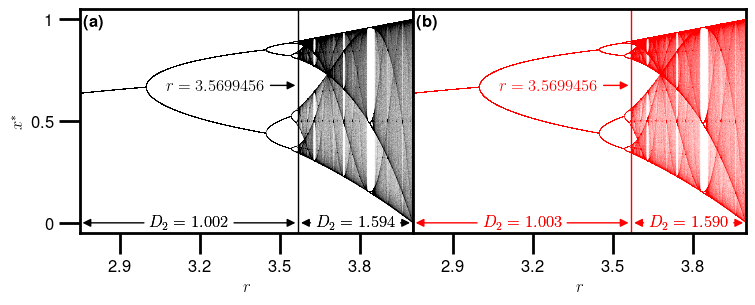

In [79]:
dimension = 'correlation' 
# dimension = 'hausdorff'
if dimension == 'correlation':
    dim_test, dim_pred = correlation_dims_test, correlation_dims_pred
    dim_label = 'D_2'
else:
    dim_test, dim_pred = hausdorff_dims_test, hausdorff_dims_pred
    dim_label = 'D_B'

fontsize=12

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, axs = plt.subplots(1,2,figsize=(7.5, 3), sharey=True)
ax1, ax2 = axs

plot_stride = 1

ax1.scatter(fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][:,0], fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][:,1],
            s=0.25, marker='.', facecolor='k', edgecolor='none', rasterized=True)
ax1.scatter(fixed_pt_test[fixed_pt_test[:,0]>=r_chaos][:,0], fixed_pt_test[fixed_pt_test[:,0]>=r_chaos][:,1],
            s=0.025, marker='.', facecolor='k', edgecolor='none', rasterized=True)

ax2.scatter(fixed_pt_pred[fixed_pt_pred[:,0]<=r_chaos][:,0], fixed_pt_pred[fixed_pt_pred[:,0]<=r_chaos][:,1],
            s=0.25, marker='.', facecolor='r', edgecolor='none', rasterized=True)
ax2.scatter(fixed_pt_pred[fixed_pt_pred[:,0]>=r_chaos][:,0], fixed_pt_pred[fixed_pt_pred[:,0]>=r_chaos][:,1],
            s=0.025, marker='.', facecolor='r', edgecolor='none', rasterized=True)

# ax1.plot(fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][::plot_stride,0],
#          fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][::plot_stride,1],'k.',ms=.03,zorder=10, rasterized=True)
# # ax1.plot(fixed_pt_test_interp[fixed_pt_test_interp[:,0]<=r_chaos][::plot_stride,0],
# #          fixed_pt_test_interp[fixed_pt_test_interp[:,0]<=r_chaos][::plot_stride,1],'k.',ms=.05,zorder=10, rasterized=True)
# ax1.plot(fixed_pt_test_interp[fixed_pt_test_interp[:,0]>=r_chaos][::plot_stride,0],
#          fixed_pt_test_interp[fixed_pt_test_interp[:,0]>=r_chaos][::plot_stride,1],'ko',ms=.005,mfc='r',zorder=10, rasterized=True)
# ax2.plot(fixed_pt_pred[fixed_pt_pred[:,0]<=r_chaos][::plot_stride,0],
#          fixed_pt_pred[fixed_pt_pred[:,0]<=r_chaos][::plot_stride,1],'.',ms=.5,zorder=10, mfc='r', mec='none', rasterized=True)
# ax2.plot(fixed_pt_pred[fixed_pt_pred[:,0]>=r_chaos][::plot_stride,0],
#          fixed_pt_pred[fixed_pt_pred[:,0]>=r_chaos][::plot_stride,1],'.',ms=.1,zorder=10, mfc='r', mec='none', rasterized=True)
# ax2.plot(fixed_pt_pred[::plot_stride,0],fixed_pt_pred[::plot_stride,1],'r.',ms=.02,zorder=10, rasterized=True)

ax1.set_ylabel(r'$x^*$',fontsize=fontsize)
# ax2.set_ylabel(r'$x^*$',fontsize=fontsize)
ax1.set_xlabel(r'$r$',fontsize=fontsize)
ax2.set_xlabel(r'$r$',fontsize=fontsize)

# plt.title('Logistic Map Bifurcation',fontsize=18)
xlim = [2.75,4]
ylim = [-0.05,1.05]
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

xlim = ax1.get_xlim()
ylim = ax1.get_ylim()


ax1.axvline(r_chaos,c='k',zorder=0,lw=1)
# ax1.plot([xlim[0],xlim[0]],ylim,'k',zorder=0,lw=2)
# ax1.fill_between([xlim[0],r_chaos],ylim[0],ylim[1],color='r',alpha=0.1)
height = 0
ax1.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_test[0]), xy=(xlim[0],height),
             xytext=(0.5*(xlim[0]+r_chaos),height), fontsize=fontsize,
             va='center', ha='center',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', fc='k'))
ax1.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_test[0]), xy=(r_chaos,height),
             xytext=(0.5*(xlim[0]+r_chaos),height), fontsize=fontsize,
             va='center', ha='center',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', fc='k'))
ax1.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_test[1]), xy=(r_chaos,height),
             xytext=(0.5*(xlim[1]+r_chaos),height), fontsize=fontsize,
             va='center', ha='center',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', fc='k'))
ax1.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_test[1]), xy=(xlim[1],height),
             xytext=(0.5*(xlim[1]+r_chaos),height), fontsize=fontsize,
             va='center', ha='center',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', fc='k'))
# height = 1
# ax1.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_test[2]), xy=(xlim[0],height),
#              xytext=(0.5*(xlim[0]+xlim[1]),height), fontsize=fontsize,
#              va='center', ha='center',
#              arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', fc='k'))
# ax1.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_test[2]), xy=(xlim[1],height),
#              xytext=(0.5*(xlim[0]+xlim[1]),height), fontsize=fontsize,
#              va='center', ha='center',
#              arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', fc='k'))


ax2.axvline(r_chaos,c='r',zorder=0,lw=1)
# ax2.plot([xlim[0],xlim[0]],ylim,'k',zorder=0,lw=2)
# ax2.fill_between([xlim[0],r_chaos],ylim[0],ylim[1],color='r',alpha=0.1)
height = 0
ax2.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_pred[0]), xy=(xlim[0],height),
             xytext=(0.5*(xlim[0]+r_chaos),height), fontsize=fontsize,
             va='center', ha='center', color='r',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='r', fc='r'))
ax2.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_pred[0]), xy=(r_chaos,height),
             xytext=(0.5*(xlim[0]+r_chaos),height), fontsize=fontsize,
             va='center', ha='center', color='r',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='r', fc='r'))
ax2.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_pred[1]), xy=(r_chaos,height),
             xytext=(0.5*(xlim[1]+r_chaos),height), fontsize=fontsize,
             va='center', ha='center', color='r',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='r', fc='r'))
ax2.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_pred[1]), xy=(xlim[1],height),
             xytext=(0.5*(xlim[1]+r_chaos),height), fontsize=fontsize,
             va='center', ha='center', color='r',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='r', fc='r'))
# height = 1
# ax2.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_pred[2]), xy=(xlim[0],height),
#              xytext=(0.5*(xlim[0]+xlim[1]),height), fontsize=fontsize,
#              va='center', ha='center', color='r',
#              arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='r', fc='r'))
# ax2.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_pred[2]), xy=(xlim[1],height),
#              xytext=(0.5*(xlim[0]+xlim[1]),height), fontsize=fontsize,
#              va='center', ha='center', color='r',
#              arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='r', fc='r'))

ax1.set_yticks([0,0.5,1])
# ax2.set_yticks([0,0.5,1])
ax1.set_yticklabels([0,0.5,1])
# ax2.set_yticklabels([0,0.5,1])
xticks = [2.9,3.2,3.5,3.8]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks)

ax1.tick_params(bottom=True, top=False, left=True, right=False)
ax2.tick_params(bottom=True, top=False, left=False, right=False)


plt.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0)
fig.align_labels([axs])


plt.setp(ax1.spines.values(), linewidth=2, zorder=100)
plt.setp(ax2.spines.values(), linewidth=2, zorder=100)
ax1.tick_params(length=15,width=2)
ax2.tick_params(length=15,width=2)
ax1.annotate(r'\textbf{(a)}', xy=(0.01,0.975), ha='left', va='top', xycoords="axes fraction", fontsize=fontsize,
              bbox=dict(boxstyle='round,pad=0.1,rounding_size=0.5',fc='w',ec=None,lw=0,alpha=1))
ax2.annotate(r'\textbf{(b)}', xy=(0.01,0.975), ha='left', va='top', xycoords="axes fraction", fontsize=fontsize,
              bbox=dict(boxstyle='round,pad=0.1,rounding_size=0.5',fc='w',ec=None,lw=0,alpha=1))

ax1.annotate(fr'$r={r_chaos}$', xy=(r_chaos,0.675), ha='right', va='center', xycoords='data', fontsize=fontsize,
             xytext=(r_chaos-0.1*np.diff(ax1.get_xlim()),0.675), textcoords='data', color='k',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='k', fc='k'))
ax2.annotate(fr'$r={r_chaos}$', xy=(r_chaos,0.675), ha='right', va='center', xycoords='data', fontsize=fontsize,
             xytext=(r_chaos-0.1*np.diff(ax2.get_xlim()),0.675), textcoords='data', color='r',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='r', fc='r'))


title = 'Predicted_Logistic_Bifurcation'
plt.savefig(fig_dir+title+'.eps',bbox_inches='tight',pad_inches=0.2, dpi=200)
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=500)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=2500)
plt.show()
plt.close(fig)